# code and date adapted and get from 
code/MNF/notebooks/STRING_Data_11.5/DownSampleSamePosandNeg_test_phylumeffect_withLowDCA_visulization_fullHomologous_oneBestHomologousPP.ipynb

# load lib and set data 

In [1]:
import sys
import os 
import pandas as pd
import numpy as np 
import math
import copy 
from collections import defaultdict
import pickle
import glob


import multiprocessing as mp 
import subprocess


import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio import SeqIO
from Bio.Blast import NCBIXML


from Bio.PDB import PDBParser

import networkx as nx



from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle

import  sklearn.metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier


from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.metrics import roc_auc_score







In [2]:

%reload_ext autoreload
%autoreload 2

sys.path.append('../src/utilities/')

from ROC_curve import DCA_RocCurve
from ROC_curve import Random_RocCurve


from Check_SameCogPair_problem import sepCogPairs_topDCAs_ML_predictions



from MSA_tools import downsample_msa
from MSA_tools import get_msa_statistics_dict




In [3]:

Query_tuple=('1224', '511145')
Subject_tupleList=[("1239","1274374"),('201174', '105422'), ('976', '411476'),] 

In [4]:
notebookData_folder="/mnt/mnemo6/tao/notebook_data/"  #"/mnt/mnemo6/tao/"
CoEvo_data_folder=f"{notebookData_folder}PPI_Coevolution/CoEvo_data_STRING11.5/"



In [5]:

EggNOG_groupPath=f"{notebookData_folder}STRING_Data_11.5/eggnog5AddSTRING11.5_Species/groups/"


In [6]:
%%time
# read cog information 
max_level="2" #"2", "1224"
EggNOG_group_level2=pd.read_csv(EggNOG_groupPath+max_level+".tsv",
                                header=None,index_col=None,sep="\t")


# CPU times: user 25.6 s, sys: 3.03 s, total: 28.7 s
# Wall time: 28.7 s


CPU times: user 22.2 s, sys: 6.75 s, total: 29 s
Wall time: 29.2 s


# downsame MSA for 1224 and 2 and 1236 use MSA at 1236 level  for 1236 as well just to make sure its not because of re-shuffle issure 
and also 1236 does always have least number of seq in their msa 

In [7]:
# save data get from 
# code/MNF/notebooks/STRING_Data_11.5/DownSampleSamePosandNeg_test_phylumeffect_withLowDCA_visulization_fullHomologous_oneBestHomologousPP.ipynb
SamePosandNeg_Benchmark=f"{notebookData_folder}PPI_Coevolution/CoEvo_data_STRING11.5/AllLevel_testPhylaEffectSamePosandNeg_Benchmark/"

SamePosandNeg_STRING115EggNog1236Spe511145_frame=pd.read_csv(SamePosandNeg_Benchmark+"SamePosandNeg_STRING115EggNog1236Spe511145.benchmark",
                                                                                                            header=0,index_col=None,sep="\t")
print(SamePosandNeg_STRING115EggNog1236Spe511145_frame.shape)
SamePosandNeg_STRING115EggNog1236Spe511145_frame.head(n=3)


(19669, 9)


,STRING_ID1,STRING_ID2,benchmark_status,maxBetDCA_score,maxBetMI_score,len1,len2,LR_onesProb,RF_onesProb
0,511145.b0014,511145.b0055,P,1.2790,0.0868,638,270,0.142476,0.362745
1,511145.b0014,511145.b0095,P,1.1044,0.1006,638,382,0.195483,0.515103
2,511145.b0014,511145.b0436,P,1.1697,0.0821,638,431,0.111612,0.284446


In [8]:

SamePosandNeg_allPPs=SamePosandNeg_STRING115EggNog1236Spe511145_frame.loc[:,["STRING_ID1","STRING_ID2"]].values.tolist()
SamePosandNeg_allPPs=[tuple(pp) for pp in SamePosandNeg_allPPs]

# prepare downsample MSA here 

In [9]:
# %%time
# #run once 
# #only run this step if the intermediated data is generated from scratch 
# # here is to downsample to the smaller paired MSAs to fixsize
# DownSample_strategy = "num"#"percent"
# DownSample_sizes=[1,2,3,5,10,50,100,200,300,500]
# for DownSample_size in DownSample_sizes:
#     for EggNOG_maxLevel,currentSpe_TaxID in [('2', '511145')]:
#         input_root_folder=CoEvo_data_folder+currentSpe_TaxID+"_EggNOGmaxLevel"+EggNOG_maxLevel+"_eggNOGfilteredData/"

#         SamePosandNeg_pairedMSA_Nf90_folder = input_root_folder+"pair_MSA_Nf90_PasteAlign/"

#         DownSample_SamePosandNeg_pairedMSA_Nf90_folder = input_root_folder+"DownSample_"+DownSample_strategy+str(DownSample_size)+"_pair_MSA_Nf90_PasteAlign/"
        
#         if not os.path.exists(DownSample_SamePosandNeg_pairedMSA_Nf90_folder):
#             os.makedirs(DownSample_SamePosandNeg_pairedMSA_Nf90_folder)
#             print(SamePosandNeg_pairedMSA_Nf90_folder,DownSample_SamePosandNeg_pairedMSA_Nf90_folder)


#             SamePosandNeg_argsFordownsample=[(pp1,pp2,
#                                             SamePosandNeg_pairedMSA_Nf90_folder,
#                                             DownSample_SamePosandNeg_pairedMSA_Nf90_folder,
#                                             DownSample_size,) for pp1,pp2 in SamePosandNeg_allPPs]

#             pool=mp.Pool(20)
#             pool.map(downsample_msa,SamePosandNeg_argsFordownsample)
#             pool.close() 
        
# # /mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel2_eggNOGfilteredData/pair_MSA_Nf90_PasteAlign/ /mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel2_eggNOGfilteredData/DownSample_num10_pair_MSA_Nf90_PasteAlign/
# # /mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel2_eggNOGfilteredData/pair_MSA_Nf90_PasteAlign/ /mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel2_eggNOGfilteredData/DownSample_num100_pair_MSA_Nf90_PasteAlign/
# # /mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel2_eggNOGfilteredData/pair_MSA_Nf90_PasteAlign/ /mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel2_eggNOGfilteredData/DownSample_num200_pair_MSA_Nf90_PasteAlign/
# # /mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel2_eggNOGfilteredData/pair_MSA_Nf90_PasteAlign/ /mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel2_eggNOGfilteredData/DownSample_num300_pair_MSA_Nf90_PasteAlign/
# # CPU times: user 1.01 s, sys: 16.9 s, total: 17.9 s
# # Wall time: 6min 46s

# COMPUTATION  use downsample MSA of same positive and negative protein pairs    at differen phylum level 1236(could be omit), 1224, 2  , 




In [10]:
# run like below 

# here because of numyp version i actually reinstalled py37_pydca
# via yaml filed failed followed tutorial in 环境配置

# (base) tao@deimos:~$ cd /mnt/mnemo5/tao/code/MNF/notebooks/STRING_Data_11.5/

# base) tao@deimos:~/code/MNF/notebooks/STRING_Data_11.5$ conda activate py37_pydca


#  and run python DownSampleSamePosandNeg_test_phylumeffect.py


# figure 2C

## statistical table for unified dataset and original MSA 
generate a data frame perhaps

check num of seq, seq lengh, average seq distance , msa seq  overlap at class level 
and conservation score/shannon entropy (https://www.biostars.org/p/133505/)

In [11]:
%%time 
SamePosandNeg_msaStats_dict_ofDict=dict()


if not os.path.exists(SamePosandNeg_Benchmark+'SamePosandNeg_msaStats_dict_ofDict.pickle'):

    for EggNOG_maxLevel,currentSpe_TaxID in [('1236', '511145'), ('1224', '511145'), ('2', '511145')]:

        input_root_folder=CoEvo_data_folder+currentSpe_TaxID+"_EggNOGmaxLevel"+EggNOG_maxLevel+"_eggNOGfilteredData/"
        SamePosandNeg_pairedMSA_Nf90_folder = input_root_folder+"pair_MSA_Nf90_PasteAlign/"
        print(SamePosandNeg_pairedMSA_Nf90_folder)

        SamePosandNeg_msaStats_list=list()

        SamePosandNeg_argsFormsaStats=[(pp1,pp2,SamePosandNeg_pairedMSA_Nf90_folder) for pp1,pp2 in SamePosandNeg_allPPs]

        pool=mp.Pool(100) # consider use 100 cpus as this is slow 
        SamePosandNeg_msaStats_list=pool.map(get_msa_statistics_dict,SamePosandNeg_argsFormsaStats)
        pool.close() 

        SamePosandNeg_msaStats_dict={(pp1,pp2):[num,mlen,mean_dist,mean_colentropy,mean_colgappercent] for pp1,pp2,num,mlen,mean_dist,mean_colentropy,mean_colgappercent in SamePosandNeg_msaStats_list}
        SamePosandNeg_msaStats_dict_ofDict[(EggNOG_maxLevel,currentSpe_TaxID)]=SamePosandNeg_msaStats_dict



    with open(SamePosandNeg_Benchmark+'SamePosandNeg_msaStats_dict_ofDict.pickle', 'wb') as handle:
        pickle.dump(SamePosandNeg_msaStats_dict_ofDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # /mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel1236_eggNOGfilteredData/pair_MSA_Nf90_PasteAlign/
    # /mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel1224_eggNOGfilteredData/pair_MSA_Nf90_PasteAlign/
    # /mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel2_eggNOGfilteredData/pair_MSA_Nf90_PasteAlign/
    # CPU times: user 47 s, sys: 56.5 s, total: 1min 43s
    # Wall time: 1h 55min 57s this take this long because deimos is oocupied to compute DCA 

    # even when server is free, its still sloow, use more cpus ! or save itermediate resutts 
    # /mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel1236_eggNOGfilteredData/pair_MSA_Nf90_PasteAlign/
    # /mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel1224_eggNOGfilteredData/pair_MSA_Nf90_PasteAlign/
    # /mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel2_eggNOGfilteredData/pair_MSA_Nf90_PasteAlign/
    # CPU times: user 1min, sys: 8min, total: 9min
    # Wall time: 1h 9min 26s

CPU times: user 795 µs, sys: 0 ns, total: 795 µs
Wall time: 25.1 ms


In [12]:

with open(SamePosandNeg_Benchmark+'SamePosandNeg_msaStats_dict_ofDict.pickle', 'rb') as handle:
    SamePosandNeg_msaStats_dict_ofDict=pickle.load(handle)

In [13]:
SamePosandNeg_msaStats_dict_ofDict.keys()

dict_keys([('1236', '511145'), ('1224', '511145'), ('2', '511145')])

In [14]:
for k, dv in SamePosandNeg_msaStats_dict_ofDict.items():
    temp_l=[]
    print(k)
    for kk, l in dv.items():
        if kk in SamePosandNeg_allPPs:
            temp_l.append(l)
    temp_array=np.round(np.array(temp_l),decimals=4)
    print(temp_array.shape)
    np.set_printoptions(suppress=True)
    print(np.median(temp_array,axis=0))
    
#num,mlen,mean_dist,mean_colentropy,mean_colgappercent
        

('1236', '511145')
(19669, 5)
[579.     562.       0.2573   0.3967   0.0159]
('1224', '511145')
(19669, 5)
[1451.      558.        0.2856    0.4484    0.0213]
('2', '511145')
(19669, 5)
[3522.      542.        0.316     0.5115    0.0337]


## statistical table for unified dataset and downsample MSA (100)
generate a data frame perhaps

check num of seq, seq lengh, average seq distance , msa seq  overlap at class level 
and conservation score/shannon entropy (https://www.biostars.org/p/133505/)

In [15]:
%%time 
DownSample100_SamePosandNeg_msaStats_dict_ofDict=dict()

if not os.path.exists(SamePosandNeg_Benchmark+'DownSample100_SamePosandNeg_msaStats_dict_ofDict.pickle'):
    for EggNOG_maxLevel,currentSpe_TaxID in [('1236', '511145'), ('1224', '511145'), ('2', '511145')]:

        input_root_folder=CoEvo_data_folder+currentSpe_TaxID+"_EggNOGmaxLevel"+EggNOG_maxLevel+"_eggNOGfilteredData/"
        DownSample100_SamePosandNeg_pairedMSA_Nf90_folder = input_root_folder+"DownSample_num100_pair_MSA_Nf90_PasteAlign/"
        print(DownSample100_SamePosandNeg_pairedMSA_Nf90_folder)

        DownSample100_SamePosandNeg_msaStats_list=list()

        DownSample100_SamePosandNeg_argsFormsaStats=[(pp1,pp2,DownSample100_SamePosandNeg_pairedMSA_Nf90_folder) for pp1,pp2 in SamePosandNeg_allPPs]

        pool=mp.Pool(100) # consider use 100 cpus as this is slow 
        DownSample100_SamePosandNeg_msaStats_list=pool.map(get_msa_statistics_dict,DownSample100_SamePosandNeg_argsFormsaStats)
        pool.close() 

        DownSample100_SamePosandNeg_msaStats_dict={(pp1,pp2):[num,mlen,mean_dist,mean_colentropy,mean_colgappercent] for pp1,pp2,num,mlen,mean_dist,mean_colentropy,mean_colgappercent in DownSample100_SamePosandNeg_msaStats_list}
        DownSample100_SamePosandNeg_msaStats_dict_ofDict[(EggNOG_maxLevel,currentSpe_TaxID)]=DownSample100_SamePosandNeg_msaStats_dict



    with open(SamePosandNeg_Benchmark+'DownSample100_SamePosandNeg_msaStats_dict_ofDict.pickle', 'wb') as handle:
        pickle.dump(DownSample100_SamePosandNeg_msaStats_dict_ofDict, handle, protocol=pickle.HIGHEST_PROTOCOL)


CPU times: user 401 µs, sys: 0 ns, total: 401 µs
Wall time: 373 µs


In [16]:

with open(SamePosandNeg_Benchmark+'DownSample100_SamePosandNeg_msaStats_dict_ofDict.pickle', 'rb') as handle:
    DownSample100_SamePosandNeg_msaStats_dict_ofDict=pickle.load(handle)

In [17]:
#DownSample100_SamePosandNeg_msaStats_list_ofList=list
for k, dv in DownSample100_SamePosandNeg_msaStats_dict_ofDict.items():
    temp_l=[]
    print(k)
    for kk, l in dv.items():
        if kk in SamePosandNeg_allPPs:
            temp_l.append(l)
    temp_array=np.round(np.array(temp_l),decimals=4)
    print(temp_array.shape)
    np.set_printoptions(suppress=True)
    print(np.median(temp_array,axis=0))
    
#num,mlen,mean_dist,mean_colentropy,mean_colgappercent
        

('1236', '511145')
(19669, 5)
[100.     562.       0.2552   0.3827   0.0158]
('1224', '511145')
(19669, 5)
[100.     558.       0.2828   0.4306   0.0214]
('2', '511145')
(19669, 5)
[100.     542.       0.3131   0.4901   0.0337]


## draw Figure 2C

In [18]:
Table1=pd.DataFrame(np.zeros((3*2,7)),
                    columns=["size","lenghth","distance","entropy","gaps","taxonomy","DownSample"])
Table1

,size,lenghth,distance,entropy,gaps,taxonomy,DownSample
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
phylumID2Name_dict={'1236':"class",'1224':"phylum",'2':"superkingdom"} 
columns_names=["class","phylum","superkingdom"]



for k, dv in SamePosandNeg_msaStats_dict_ofDict.items():
    print(k)
    phylumName=phylumID2Name_dict[k[0]]
    idx=columns_names.index(phylumName)
    
    
    temp_l=[]
    for kk, l in dv.items():
        if kk in SamePosandNeg_allPPs:
            temp_l.append(l)
            
    temp_array=np.round(np.array(temp_l),decimals=3)
    # temp_array=np.array(temp_l)
    Table1.iloc[idx,:-2]=np.median(temp_array,axis=0)
    Table1.iloc[idx,-2:]=[phylumName,"No"]
        
        

for k, dv in DownSample100_SamePosandNeg_msaStats_dict_ofDict.items():
    print(k)
    phylumName=phylumID2Name_dict[k[0]]
    idx=columns_names.index(phylumName)+3
    temp_l=[]
    for kk, l in dv.items():
        if kk in SamePosandNeg_allPPs:
            temp_l.append(l)
            
    temp_array=np.round(np.array(temp_l),decimals=3)
    # temp_array=np.array(temp_l)
    Table1.iloc[idx,:-2]=np.median(temp_array,axis=0)
    Table1.iloc[idx,-2:]=[phylumName,"Yes"]
        

('1236', '511145')
('1224', '511145')
('2', '511145')
('1236', '511145')
('1224', '511145')
('2', '511145')


In [20]:
Table1

,size,lenghth,distance,entropy,gaps,taxonomy,DownSample
0,579.0,562.0,0.257,0.397,0.016,class,No
1,1451.0,558.0,0.286,0.448,0.021,phylum,No
2,3522.0,542.0,0.316,0.512,0.034,superkingdom,No
3,100.0,562.0,0.255,0.383,0.016,class,Yes
4,100.0,558.0,0.283,0.431,0.021,phylum,Yes
5,100.0,542.0,0.313,0.490,0.034,superkingdom,Yes


In [21]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

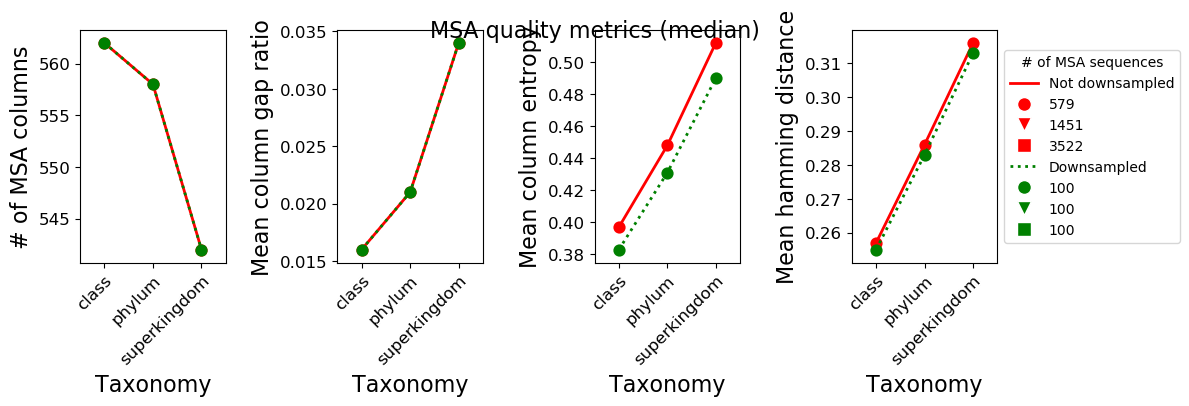

In [62]:
figure=plt.figure(figsize=(12,4))

st = figure.suptitle("MSA quality metrics (median)", fontsize="16")

ax4 = plt.subplot(1,4,1)#plt.subplot(1,4,4)
sns.pointplot(data=Table1,
             y="lenghth",
             x="taxonomy",
            hue="DownSample",
              # markers=["x","+"],#"v",
              linestyles=["-","dotted"],#"-",
              # legend=False,
              palette=['r', 'g'],
              ax=ax4,
            # hue_order=["N","other_pos","pdb_complex","pdb_contact"]
            )
ax4.legend().set_visible(False)
plt.setp(ax4.lines, linewidth=2)  
plt.xlabel("Taxonomy",fontsize=16) # loc='center',
# plt.ylabel("MSA length",fontsize=16)
plt.ylabel("# of MSA columns",fontsize=16)
plt.xticks(fontsize=12,rotation=45,ha="right",rotation_mode="anchor") # ,ha="right"
plt.yticks(fontsize=12)


ax3 = plt.subplot(1,4,2)
sns.pointplot(data=Table1,
             y="gaps",
             x="taxonomy",
            hue="DownSample",
              # markers=["x","+"],#"v",
              linestyles=["-","dotted"],#"-",
              # legend=False,
              palette=['r', 'g'],
              ax=ax3,
            # hue_order=["N","other_pos","pdb_complex","pdb_contact"]
            )
ax3.legend().set_visible(False)
plt.setp(ax3.lines, linewidth=2)  
plt.xlabel("Taxonomy",fontsize=16) # loc='center',
plt.ylabel("Mean column gap ratio",fontsize=16)
plt.xticks(fontsize=12,rotation=45,ha="right",rotation_mode="anchor")
plt.yticks(fontsize=12)



ax2 = plt.subplot(1,4,3)
sns.pointplot(data=Table1,#.loc[Table1["DownSample"]=="Yes",]
             y="entropy",
             x="taxonomy",
              hue="DownSample",
              # markers="v",#"o",#"s",
             linestyles=["-","dotted"],#"--",
              # legend=False,
              palette=['r',"g"],
              ax=ax2,
            # hue_order=["N","other_pos","pdb_complex","pdb_contact"]
            )

ax2.legend().set_visible(False)
plt.setp(ax2.lines, linewidth=2)  
plt.xlabel("Taxonomy",fontsize=16) # loc='center',
plt.ylabel("Mean column entropy",fontsize=16)
plt.xticks(fontsize=12,rotation=45,ha="right",rotation_mode="anchor")
plt.yticks(fontsize=12)


ax1 = plt.subplot(1,4,4) #plt.subplot(1,3,1)

sns.pointplot(data=Table1,
             y="distance",
             x="taxonomy",
            hue="DownSample",
            # markers=["o","v","s"],#"8",# https://matplotlib.org/3.1.0/api/markers_api.html
             linestyles=["-","dotted"],
              # legend=False,
               palette=['r', 'g'],
              ax=ax1,
              
            )
ax1.legend().set_visible(False)
plt.setp(ax1.lines, linewidth=2)  
plt.xlabel("Taxonomy",fontsize=16) # loc='center',
plt.ylabel("Mean hamming distance",fontsize=16)
plt.xticks(fontsize=12,rotation=45,ha="right",rotation_mode="anchor")
plt.yticks(fontsize=12)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
#            # title="Random Sample",
#            # labels=['Yes', 'NO'],labelcolor=["blue","yellow"]
#           )




#https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
legend_elements = [Line2D([0], [0],color='r',linestyle="-",linewidth=2, label='Not downsampled',# 'Yes,579',
                         ),
                   
                    Line2D([0], [0],  marker='o', color='w', label='579',# 'Yes,579',
                           markerfacecolor='r', markersize=10,
                         ),
                   
                   Line2D([0], [0],marker='v', color='w', label='1451',
                          markerfacecolor='r', markersize=10,
                         ),
                   
                  Line2D([0], [0], marker='s',color='w', label='3522',
                         markerfacecolor='r', markersize=10,
                        ),
                   
                   Line2D([0], [0],color='g',linestyle="dotted",linewidth=2, label='Downsampled',
                          
                         ),
                   
                   Line2D([0], [0],marker='o', color='w', label='100',
                          markerfacecolor='g', markersize=10,
                         ),
                   
                  Line2D([0], [0], marker='v',color='w',label='100',
                          markerfacecolor='g', markersize=10,
                        ),
                   
                   Line2D([0], [0], marker='s',color='w',label='100',
                           markerfacecolor='g', markersize=10,
                         ),
                  ]



plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          handles=legend_elements,
          title="# of MSA sequences",#title="MSA size",
          )



plt.tight_layout()
plt.show()


figure.savefig("/mnt/mnemo5/tao/temp_figures/figure1_table1.pdf", dpi=600)
# for marker type in the plot, could be adjust by affinity designer 
# by delete it, and fill in with new object with old coordiate

# compare roc at differen phylum level 1236, 1224, 2  , use same positive and negative protein pairs not downsample msa  VISULIZATION



In [23]:
%%time 
testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1224Spe511145_topDCAs_predicted_results=sepCogPairs_topDCAs_ML_predictions(EggNOG_maxLevel="1224",currentSpe_TaxID="511145",STRING_Version="11.5",
                                                                                          EggNOG_group_level2=EggNOG_group_level2,
                                                                           ML_methods=["LR","RF"],
                                                                           DCA_thres=0,DCA_number=50,selDca_number=20,
                                                                            CoEvo_data_folder=CoEvo_data_folder,                                      
                                                                            benchmark_suffix="testPhylaEffectNotDownSampleSamePPs_Benchmark/",
                                                                                        sort_frame=False,
                                                                                        ifReCollect=True,#True,                
                                                                                        saveFrame=True,
                                                                                        overwrite=False,
                                                                                        )
# CPU times: user 31.6 s, sys: 20.2 s, total: 51.9 s
# Wall time: 1min 56s


ML_inputs: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel1224_eggNOGfilteredData/testPhylaEffectNotDownSampleSamePPs_Benchmark/ML_inputs/
Benchmark_folder: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel1224_eggNOGfilteredData/testPhylaEffectNotDownSampleSamePPs_Benchmark/
allPPI_allInfo_frame.shape: (19669, 9)
Pos_allPPI_allInfo_frame.shape: (3420, 9)
Neg_allPPI_allInfo_frame.shape: (16249, 9)
allPPI_allInfo_frame.shape: (19669, 9)
len(CurrentSpe_EggNOG_group_level2_pro2cog): 4036
len(allPPI_cogs): 19669
len(allPPI_info): 19669
top_CoEvo_frame.shape: (19669, 152)
sys.getsizeof(top_CoEvo_frame)/(1024*1024*1024):0.024509863927960396
Re collect data 
X_fileName: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel1224_eggNOGfilteredData/testPhylaEffectNotDownSampleSamePPs_Benchmark/ML_inputs/DCA_thres_0_NonPara_X_topDCADCA_thres_0s_Num50.npy
Y_fileName: /mnt/mnemo6/ta

In [24]:
testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1236Spe511145_topDCAs_predicted_results=sepCogPairs_topDCAs_ML_predictions(EggNOG_maxLevel="1236",currentSpe_TaxID="511145",STRING_Version="11.5",
                                                                           EggNOG_group_level2=EggNOG_group_level2,
                                                                           ML_methods=["LR","RF"],
                                                                           DCA_thres=0,DCA_number=50,selDca_number=20,
                                                                           CoEvo_data_folder=CoEvo_data_folder,
                                                                            benchmark_suffix="testPhylaEffectNotDownSampleSamePPs_Benchmark/",
                                                                                        sort_frame=False,
                                                                                        ifReCollect=True,
                                                                                         saveFrame=True,
                                                                                        overwrite=False,
                                                                                         )


# here order is little different as allPPI dataframe was reorder , its a problem across taximical lever or with different MSA 

ML_inputs: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel1236_eggNOGfilteredData/testPhylaEffectNotDownSampleSamePPs_Benchmark/ML_inputs/
Benchmark_folder: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel1236_eggNOGfilteredData/testPhylaEffectNotDownSampleSamePPs_Benchmark/
allPPI_allInfo_frame.shape: (19669, 9)
Pos_allPPI_allInfo_frame.shape: (3420, 9)
Neg_allPPI_allInfo_frame.shape: (16249, 9)
allPPI_allInfo_frame.shape: (19669, 9)
len(CurrentSpe_EggNOG_group_level2_pro2cog): 4036
len(allPPI_cogs): 19669
len(allPPI_info): 19669
top_CoEvo_frame.shape: (19669, 152)
sys.getsizeof(top_CoEvo_frame)/(1024*1024*1024):0.024509863927960396
Re collect data 
X_fileName: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel1236_eggNOGfilteredData/testPhylaEffectNotDownSampleSamePPs_Benchmark/ML_inputs/DCA_thres_0_NonPara_X_topDCADCA_thres_0s_Num50.npy
Y_fileName: /mnt/mnemo6/ta

In [25]:
'/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel2_eggNOGfilteredData/testPhylaEffectNotDownSampleSamePPs_Benchmark/allPPI_allInfo_frame.csv'

'/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel2_eggNOGfilteredData/testPhylaEffectNotDownSampleSamePPs_Benchmark/allPPI_allInfo_frame.csv'

In [26]:
testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results=sepCogPairs_topDCAs_ML_predictions(EggNOG_maxLevel="2",currentSpe_TaxID="511145",STRING_Version="11.5",
                                                                           EggNOG_group_level2=EggNOG_group_level2,
                                                                           ML_methods=["LR","RF"],
                                                                           DCA_thres=0,DCA_number=50,selDca_number=20,
                                                                            CoEvo_data_folder=CoEvo_data_folder,
                                                                            benchmark_suffix="testPhylaEffectNotDownSampleSamePPs_Benchmark/",
                                                                                        sort_frame=False,
                                                                                        ifReCollect=True,
                                                                                         saveFrame=True,
                                                                                        overwrite=False,                                  
                                                                                        )



ML_inputs: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel2_eggNOGfilteredData/testPhylaEffectNotDownSampleSamePPs_Benchmark/ML_inputs/
Benchmark_folder: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel2_eggNOGfilteredData/testPhylaEffectNotDownSampleSamePPs_Benchmark/
allPPI_allInfo_frame.shape: (19669, 9)
Pos_allPPI_allInfo_frame.shape: (3420, 9)
Neg_allPPI_allInfo_frame.shape: (16249, 9)
allPPI_allInfo_frame.shape: (19669, 9)
len(CurrentSpe_EggNOG_group_level2_pro2cog): 4036
len(allPPI_cogs): 19669
len(allPPI_info): 19669
top_CoEvo_frame.shape: (19669, 152)
sys.getsizeof(top_CoEvo_frame)/(1024*1024*1024):0.024509863927960396
Re collect data 
X_fileName: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel2_eggNOGfilteredData/testPhylaEffectNotDownSampleSamePPs_Benchmark/ML_inputs/DCA_thres_0_NonPara_X_topDCADCA_thres_0s_Num50.npy
Y_fileName: /mnt/mnemo6/tao/noteboo

In [27]:
testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results.keys()

dict_keys(['XtopDCAs', 'YtopDCAs', 'XtopDCAs_train', 'XtopDCAs_test', 'ytopDCAs_train', 'ytopDCAs_test', 'LR', 'RF', 'updated_allPPI_allInfo_frame'])

# compare roc at didfferenet taxoni level  , but with different MSA downsample size 


In [28]:
%%time 
#once 
phylum2spe_list=[('1236', '511145'),('1224', '511145'),("2", "511145"),] 
DownSample_strategy = "num"#"percent"
DownSample_sizes=[3,5,10,50,100,200,300]


#testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict=dict()
try:
    print(testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict.keys())
except:
    testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict=dict()
for DownSample_size in DownSample_sizes:
    for current_EggNOG_maxLevel,currentSpe_TaxID in phylum2spe_list: 
        DownSamplePrefix="DownSample_"+DownSample_strategy+str(DownSample_size)+"_"
        #print(current_EggNOG_maxLevel,currentSpe_TaxID, DownSamplePrefix)
        if (current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size) not in testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict:
            print(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)

    
            testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]=sepCogPairs_topDCAs_ML_predictions(EggNOG_maxLevel=current_EggNOG_maxLevel,
            currentSpe_TaxID=currentSpe_TaxID,STRING_Version="11.5",
            EggNOG_group_level2=EggNOG_group_level2,
            ML_methods=["LR","RF"],
            DCA_thres=0,DCA_number=50,selDca_number=20,
            CoEvo_data_folder=CoEvo_data_folder,
            benchmark_suffix=DownSamplePrefix+"testPhylaEffectDownSampleSamePPs_Benchmark/",
            downsample_prefix=DownSamplePrefix,
            sort_frame=False,
            # ifReCollect=True,                
            # saveFrame=True,
            # overwrite=True,
            ifReCollect=False,                
            saveFrame=False,
            overwrite=False,
            )



# save_allPPI_allInfo_file: /mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel2_eggNOGfilteredData/DownSample_num300_testPhylaEffectDownSampleSamePPs_Benchmark/ML_inputs/DCA_thres_0sepCogPairs_FullDataset_ML_onesProb.csv
# CPU times: user 5min 13s, sys: 2min 59s, total: 8min 12s
# Wall time: 16min 19s

1236 511145 num 3
ML_inputs: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel1236_eggNOGfilteredData/DownSample_num3_testPhylaEffectDownSampleSamePPs_Benchmark/ML_inputs/
Benchmark_folder: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel1236_eggNOGfilteredData/DownSample_num3_testPhylaEffectDownSampleSamePPs_Benchmark/
allPPI_allInfo_frame.shape: (19669, 7)
Pos_allPPI_allInfo_frame.shape: (3420, 7)
Neg_allPPI_allInfo_frame.shape: (16249, 7)
allPPI_allInfo_frame.shape: (19669, 7)
len(CurrentSpe_EggNOG_group_level2_pro2cog): 4036
len(allPPI_cogs): 19669
len(allPPI_info): 19669
top_CoEvo_frame.shape: (19669, 152)
sys.getsizeof(top_CoEvo_frame)/(1024*1024*1024):0.024509863927960396
OnlyTopPosNeg_NonPara_XtopDCAs.ndim: 2
XtopDCAs_train.shape,XtopDCAs_test.shape,ytopDCAs_train.shape,ytopDCAs_test.shape: (15735, 20) (3934, 20) (15735,) (3934,)
[['COG1157', 'COG0186'], ['COG3073', 'COG0255'], ['COG0782', 'COG1651

In [29]:
testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict.keys()

dict_keys([('1236', '511145', 'num', 3), ('1224', '511145', 'num', 3), ('2', '511145', 'num', 3), ('1236', '511145', 'num', 5), ('1224', '511145', 'num', 5), ('2', '511145', 'num', 5), ('1236', '511145', 'num', 10), ('1224', '511145', 'num', 10), ('2', '511145', 'num', 10), ('1236', '511145', 'num', 50), ('1224', '511145', 'num', 50), ('2', '511145', 'num', 50), ('1236', '511145', 'num', 100), ('1224', '511145', 'num', 100), ('2', '511145', 'num', 100), ('1236', '511145', 'num', 200), ('1224', '511145', 'num', 200), ('2', '511145', 'num', 200), ('1236', '511145', 'num', 300), ('1224', '511145', 'num', 300), ('2', '511145', 'num', 300)])

1236 511145 DownSample_num3_
1224 511145 DownSample_num3_
2 511145 DownSample_num3_
1236 511145 DownSample_num5_
1224 511145 DownSample_num5_
2 511145 DownSample_num5_
1236 511145 DownSample_num10_
1224 511145 DownSample_num10_
2 511145 DownSample_num10_
1236 511145 DownSample_num50_
1224 511145 DownSample_num50_
2 511145 DownSample_num50_
1236 511145 DownSample_num100_
1224 511145 DownSample_num100_
2 511145 DownSample_num100_
1236 511145 DownSample_num200_
1224 511145 DownSample_num200_
2 511145 DownSample_num200_
1236 511145 DownSample_num300_
1224 511145 DownSample_num300_
2 511145 DownSample_num300_


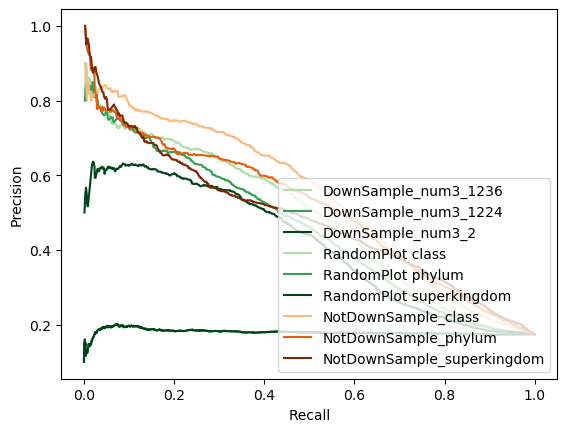

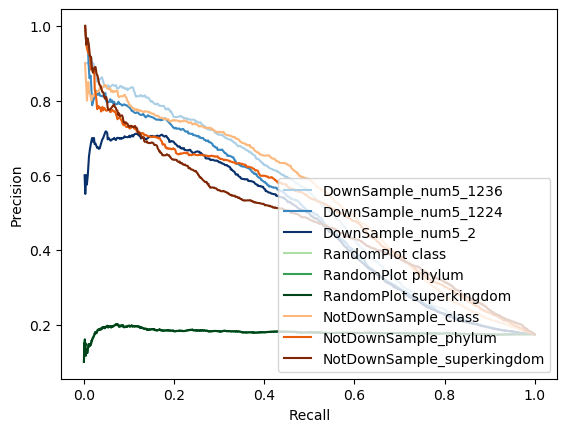

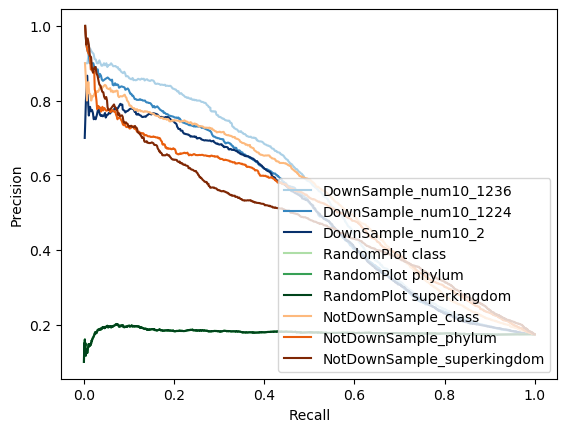

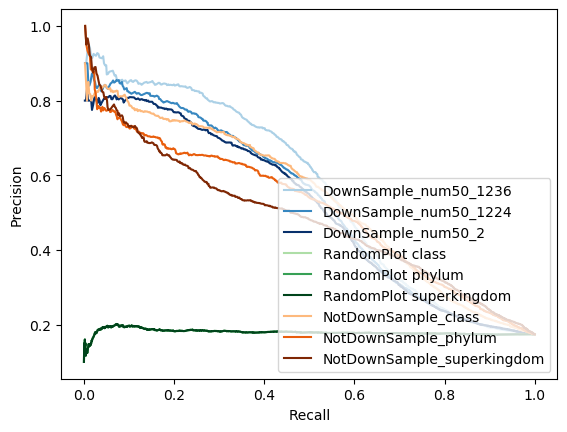

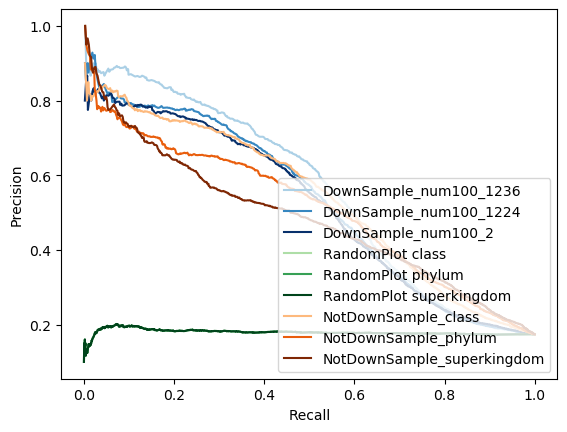

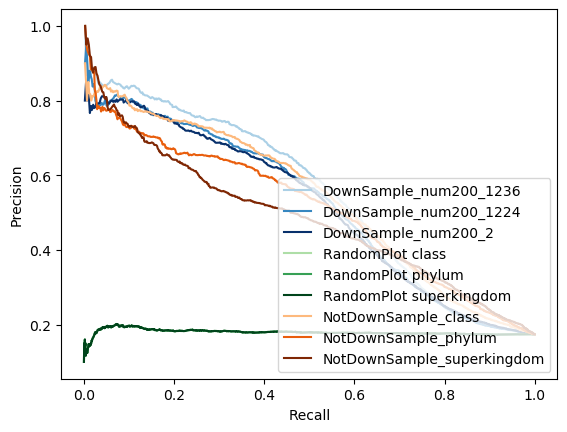

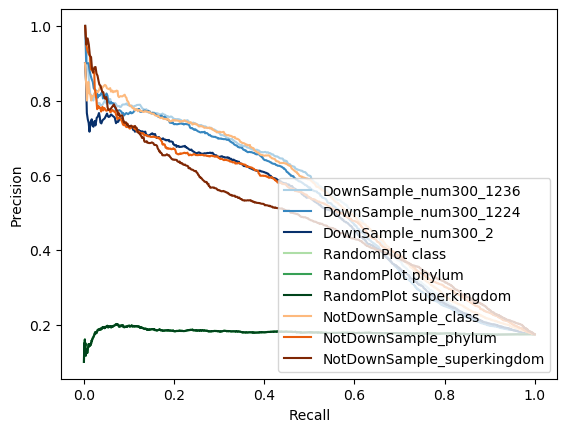

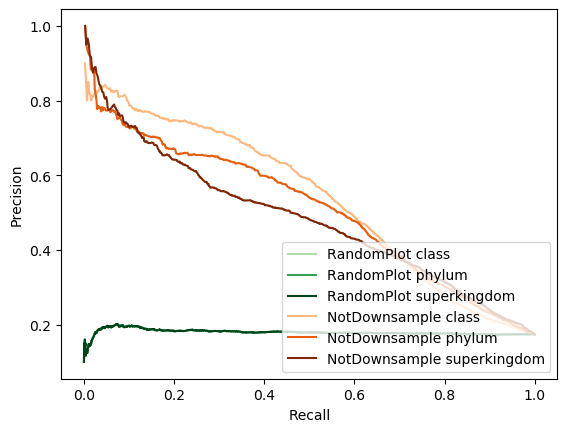

CPU times: user 4.65 s, sys: 101 ms, total: 4.75 s
Wall time: 4.74 s


In [30]:
%%time
ifplot=True
plotType="PR"
return_metrics=True

count_label="rate"
step=10
zoom_thres=None
tiny_randomnoise_range=1e-7 # noice DCA is roumnd to 4 floating digits 

phylum2spe_list=[('1236', '511145'),('1224', '511145'),("2", "511145"),] 

DownSample_strategy = "num"#"percent"
DownSample_sizes=[0,3,5,10,50,100,200,300,600] #[3,5,10,50,100,200,300]
DownSample_sizes_lable=["RandomPlot",3,5, 10, 50, 100, 200, 300,"NotDownSample"]
columns_names=["class","phylum","superkingdom"]


Taxa_ROCAUC_table=pd.DataFrame(np.zeros((len(DownSample_sizes),3)),
                         index=DownSample_sizes_lable,
                         columns=columns_names)

Taxa_PRAUC_table=pd.DataFrame(np.zeros((len(DownSample_sizes),3)),
                         index=DownSample_sizes_lable,
                         columns=columns_names)

Taxa_F1_table=pd.DataFrame(np.zeros((len(DownSample_sizes),3)),
                         index=DownSample_sizes_lable,
                         columns=columns_names)

Taxa_ACC_table=pd.DataFrame(np.zeros((len(DownSample_sizes),3)),
                         index=DownSample_sizes_lable,
                         columns=columns_names)

#all_color_names= ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', "RdPu"]
all_color_names= ['Greens','Blues', 'Blues', 'Blues', 'Blues', 'Blues', 'Blues','Oranges']


for i,DownSample_size in enumerate(DownSample_sizes[1:-1]):
    #https://matplotlib.org/stable/tutorials/colors/colormaps.html
    # plot_color_gradients('Sequential',
    #                  ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
    #                   'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
    #                   'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'])
    #https://stackoverflow.com/questions/25408393/getting-individual-colors-from-a-color-map-in-matplotlib
    plt.figure()
    
    cmap = matplotlib.cm.get_cmap(all_color_names[i])
    for j,l in enumerate(phylum2spe_list): 
        current_EggNOG_maxLevel,currentSpe_TaxID=l 
        DownSamplePrefix="DownSample_"+DownSample_strategy+str(DownSample_size)+"_"
        
        print(current_EggNOG_maxLevel,currentSpe_TaxID, DownSamplePrefix)

        ROC_AUC,PR_AUC,F1_score_lastStep,ACC_lastStep=DCA_RocCurve(testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]["XtopDCAs"][:,0], 
                     testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]["YtopDCAs"],
                     count_label=count_label,legend=DownSamplePrefix+ current_EggNOG_maxLevel,step=step,
                     zoom_thres=zoom_thres,tiny_randomnoise_range=tiny_randomnoise_range,
                        color = cmap((j+1)/3),
                    return_metrics=return_metrics,ifplot=ifplot,plotType=plotType)
        
        Taxa_ROCAUC_table.loc[DownSample_size,columns_names[j]]=ROC_AUC
        Taxa_PRAUC_table.loc[DownSample_size,columns_names[j]]=PR_AUC
        
        Taxa_F1_table.loc[DownSample_size,columns_names[j]]=F1_score_lastStep
        Taxa_ACC_table.loc[DownSample_size,columns_names[j]]=ACC_lastStep
        
        
        
    cmap = matplotlib.cm.get_cmap(all_color_names[0])
    for column_name in columns_names:
        if column_name=="superkingdom":
            temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results
            cmap_idx=3
        elif column_name=="phylum":
            temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1224Spe511145_topDCAs_predicted_results
            cmap_idx=2
        elif column_name=="class":
            temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1236Spe511145_topDCAs_predicted_results
            cmap_idx=1

        ROC_AUC,PR_AUC,F1_score_lastStep,ACC_lastStep=DCA_RocCurve(temp_results["XtopDCAs"][:,0], 
                     temp_results["YtopDCAs"],
                     count_label=count_label,legend=f"RandomPlot {column_name}",step=step,
                     zoom_thres=zoom_thres,tiny_randomnoise_range=tiny_randomnoise_range,
                    color = cmap(cmap_idx/3),
                     return_metrics=return_metrics,ifplot=ifplot,plotType=plotType,
                                                                randomplot=True)
        
    cmap = matplotlib.cm.get_cmap(all_color_names[-1])
    for column_name in columns_names:
        if column_name=="superkingdom":
            temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results
            cmap_idx=3
        elif column_name=="phylum":
            temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1224Spe511145_topDCAs_predicted_results
            cmap_idx=2
        elif column_name=="class":
            temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1236Spe511145_topDCAs_predicted_results
            cmap_idx=1
            
        ROC_AUC,PR_AUC,F1_score_lastStep,ACC_lastStep=DCA_RocCurve(temp_results["XtopDCAs"][:,0], 
                     temp_results["YtopDCAs"],
                     count_label=count_label,legend=f"NotDownSample_{column_name}",
                     step=step,zoom_thres=zoom_thres,tiny_randomnoise_range=tiny_randomnoise_range,
                    color = cmap(cmap_idx/3),
                     return_metrics=return_metrics,ifplot=ifplot,
                    plotType=plotType)


        
plt.figure()


cmap = matplotlib.cm.get_cmap(all_color_names[0])
for column_name in columns_names:
    if column_name=="superkingdom":
        temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results
        cmap_idx=3
    elif column_name=="phylum":
        temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1224Spe511145_topDCAs_predicted_results
        cmap_idx=2
    elif column_name=="class":
        temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1236Spe511145_topDCAs_predicted_results
        cmap_idx=1

    ROC_AUC,PR_AUC,F1_score_lastStep,ACC_lastStep=DCA_RocCurve(temp_results["XtopDCAs"][:,0], 
                 temp_results["YtopDCAs"],
                 count_label=count_label,legend=f"RandomPlot {column_name}",step=step,
                 zoom_thres=zoom_thres,tiny_randomnoise_range=tiny_randomnoise_range,
                color = cmap(cmap_idx/3),
                 return_metrics=return_metrics,ifplot=ifplot,plotType=plotType,
                                                            randomplot=True)
    Taxa_ROCAUC_table.loc["RandomPlot",column_name]=ROC_AUC
    Taxa_PRAUC_table.loc["RandomPlot",column_name]=PR_AUC
    Taxa_F1_table.loc["RandomPlot",column_name]=F1_score_lastStep
    Taxa_ACC_table.loc["RandomPlot",column_name]=ACC_lastStep

    

cmap = matplotlib.cm.get_cmap(all_color_names[-1])
for column_name in columns_names:
    if column_name=="superkingdom":
        temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results
        cmap_idx=3
    elif column_name=="phylum":
        temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1224Spe511145_topDCAs_predicted_results
        cmap_idx=2
    elif column_name=="class":
        temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1236Spe511145_topDCAs_predicted_results
        cmap_idx=1

    ROC_AUC,PR_AUC,F1_score_lastStep,ACC_lastStep=DCA_RocCurve(temp_results["XtopDCAs"][:,0], 
                 temp_results["YtopDCAs"],
                 count_label=count_label,legend=f"NotDownsample {column_name}",step=step,
                 zoom_thres=zoom_thres,tiny_randomnoise_range=tiny_randomnoise_range,
                color = cmap(cmap_idx/3),
                 return_metrics=return_metrics,ifplot=ifplot,plotType=plotType)
    Taxa_ROCAUC_table.loc["NotDownSample",column_name]=ROC_AUC
    Taxa_PRAUC_table.loc["NotDownSample",column_name]=PR_AUC
    Taxa_F1_table.loc["NotDownSample",column_name]=F1_score_lastStep
    Taxa_ACC_table.loc["NotDownSample",column_name]=ACC_lastStep

plt.show()
                                     
                    

In [31]:
Taxa_ROCAUC_table


,class,phylum,superkingdom
RandomPlot,0.5114,0.5114,0.5114
3,0.7493,0.7320,0.7097
5,0.7506,0.7387,0.7342
10,0.7571,0.7459,0.7442
50,0.7609,0.7522,0.7496
100,0.7660,0.7570,0.7574
200,0.7695,0.7619,0.7626
300,0.7759,0.7645,0.7657
NotDownSample,0.7866,0.7922,0.7893


In [32]:
Taxa_PRAUC_table


,class,phylum,superkingdom
RandomPlot,0.1794,0.1794,0.1794
3,0.4823,0.4540,0.4114
5,0.5167,0.4870,0.4589
10,0.5439,0.5073,0.4923
50,0.5578,0.5225,0.5082
100,0.5570,0.5256,0.5157
200,0.5459,0.5187,0.5122
300,0.5317,0.5177,0.4925
NotDownSample,0.5351,0.5071,0.4816


In [33]:
Taxa_F1_table


,class,phylum,superkingdom
RandomPlot,0.296187,0.296187,0.296187
3,0.296360,0.296274,0.296274
5,0.296187,0.296360,0.296274
10,0.296187,0.296274,0.296187
50,0.296274,0.296360,0.296274
100,0.296274,0.296360,0.296187
200,0.296360,0.296187,0.296274
300,0.296360,0.296187,0.296187
NotDownSample,0.296360,0.296360,0.296360


In [34]:
Taxa_ACC_table


,class,phylum,superkingdom
RandomPlot,0.174132,0.174132,0.174132
3,0.174335,0.174234,0.174234
5,0.174132,0.174335,0.174234
10,0.174132,0.174234,0.174132
50,0.174234,0.174335,0.174234
100,0.174234,0.174335,0.174132
200,0.174335,0.174132,0.174234
300,0.174335,0.174132,0.174132
NotDownSample,0.174335,0.174335,0.174335


# Figure 2A, 2B


2 511145 3
2 511145 10
2 511145 50
2 511145 100
2 511145 300


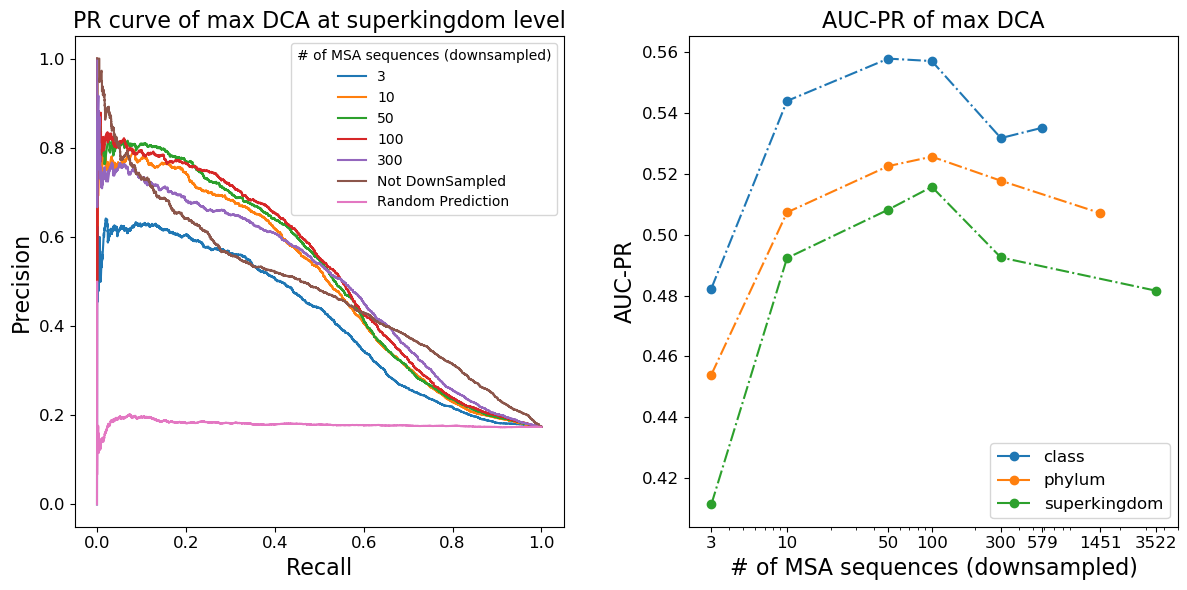

CPU times: user 26.1 s, sys: 307 ms, total: 26.5 s
Wall time: 26.2 s


In [35]:
%%time 
# DownSample_sizes=[3,5,10,50,100,200,300,600] #[3,5,10,50,100,200,300]
# DownSample_sizes_lable=[3, 5,10, 50, 100, 200, 300,"NotDownSample"]
DownSample_sizes=[3,10,50,100,300,600] #[3,5,10,50,100,200,300]
DownSample_sizes_lable=[3,10, 50, 100, 300,"NotDownSample"]


displayed_downsamplesizes=[3,10,50,100,300]

tiny_randomnoise_range=1e-7 # noice DCA is roumnd to 4 floating digits 

phylum2spe_list=[("2", "511145"),] 

DownSample_strategy = "num"#"percent"


step=1 # in the end set as 1,  for testing reason set as 100,10 at least as its slow 


fig1c = plt.figure(figsize=(12,6)) #plt.figure(figsize=(15,6)) figsize=(15,15)

ax1 = plt.subplot(1,2,1) #plt.subplot(1,3,1)
figure_handle=ax1

zoom_thres=None
plotType= "PR" #"PR" #"ROC"
count_label="rate"
for DownSample_size in displayed_downsamplesizes:
    for current_EggNOG_maxLevel,currentSpe_TaxID in phylum2spe_list: 
        #DownSamplePrefix="DownSample_"+DownSample_strategy+str(DownSample_size)+"_"
        # DownSamplePrefix=DownSample_strategy+str(DownSample_size)
        DownSamplePrefix=str(DownSample_size)
        print(current_EggNOG_maxLevel,currentSpe_TaxID, DownSamplePrefix)

        DCA_RocCurve(testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]["XtopDCAs"][:,0], 
                     testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]["YtopDCAs"],
                     count_label=count_label,legend=DownSamplePrefix,
                     step=step,zoom_thres=zoom_thres,
                     tiny_randomnoise_range=tiny_randomnoise_range,
                    figure_handle=figure_handle,
                    plotType=plotType)


DCA_RocCurve(testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results["XtopDCAs"][:,0], 
             testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results["YtopDCAs"],
             count_label=count_label,legend="Not DownSampled",
             step=step,zoom_thres=zoom_thres,
             tiny_randomnoise_range=tiny_randomnoise_range,
             figure_handle=figure_handle,
            plotType=plotType)

DCA_RocCurve(testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results["XtopDCAs"][:,0], 
             testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results["YtopDCAs"],
             count_label=count_label,legend="Random Prediction",
             step=step,zoom_thres=zoom_thres,
             tiny_randomnoise_range=tiny_randomnoise_range,
             figure_handle=figure_handle,
            plotType=plotType,
            randomplot= True)

#plt.legend(bbox_to_anchor=(1.8,0), loc="lower right")
# ax1.set_title("PR_DownSampling_superkingdom",loc='center',fontsize=16)

ax1.legend().set_visible(False)
ax1.set_xlabel("Recall",fontsize=16)
ax1.set_ylabel("Precision",fontsize=16)
ax1.set_title("PR curve of max DCA at superkingdom level",loc='center',fontsize=16)
ax1.legend(title="# of MSA sequences (downsampled)",
           # loc="upper right",
           # loc='center left', bbox_to_anchor=(1, 0.5),
           fontsize=10,
          )
plt.xticks(fontsize=12)# compare with ax2.set_xticks, this one dont need to give exact ticks position
plt.yticks(fontsize=12)
# ax1.text(-0.01, 0.9, 'A', weight='bold')# add A, B in slides 



ax2 = plt.subplot(1,2,2)
#here actuall for no downsample, msa size are differenet at different taxonomy 
class_DownSample_sizes=DownSample_sizes[:-1]+[579]
phylum_DownSample_sizes=DownSample_sizes[:-1]+[1451]
superkingdom_DownSample_sizes=DownSample_sizes[:-1]+[3522]

ax2.plot(class_DownSample_sizes,list(Taxa_PRAUC_table.loc[DownSample_sizes_lable,"class"]),label="class",
        linestyle="-.",marker="o")
ax2.plot(phylum_DownSample_sizes,list(Taxa_PRAUC_table.loc[DownSample_sizes_lable,"phylum"]),label="phylum",
        linestyle="-.",marker="o")
ax2.plot(superkingdom_DownSample_sizes,list(Taxa_PRAUC_table.loc[DownSample_sizes_lable,"superkingdom"]),label="superkingdom",
        linestyle="-.",marker="o")

# ax2.set_xticks(DownSample_sizes,DownSample_sizes_lable,rotation=45,fontsize=10,)
# ax2.set_xticks(DownSample_sizes,DownSample_sizes_lable,rotation=40)
ax2.set_xscale("log")
# ax2.set_xticks(DownSample_sizes[:-1]+[579,1451,3522],
#                DownSample_sizes[:-1]+[579,1451,3522],
#                ) # rotation=40
ax2.set_xticks(DownSample_sizes[:-1]+[579,1451,3522],   #here code change for enviroment py38_notebook
               ) # rotation=40
ax2.set_xticklabels(DownSample_sizes[:-1]+[579,1451,3522],
               ) # rotation=40

plt.xticks(fontsize=12)# compare with ax2.set_xticks, this one dont need to give exact ticks position
plt.yticks(fontsize=12)
# ax2.(fontsize=10,)
ax2.set_title("AUC-PR of max DCA",fontsize=16)
# ax2.set_xlabel("# of MSA sequences (downsampled)",loc='center',fontsize=16)
ax2.set_xlabel("# of MSA sequences (downsampled)",fontsize=16) #,loc='center'
ax2.set_ylabel("AUC-PR",fontsize=16)
# ax2.set_xscale("logit")
# ax2.set_ylabel("AUC-PR",loc='center',fontsize=10)

#plt.ylim([,])
#plt.legend(bbox_to_anchor=(1.6,0),loc="lower right")ls
ax2.legend(loc="lower right",fontsize=12)



fig1c.tight_layout()


plt.show()


# # when step as 10
# CPU times: user 9min, sys: 2.15 s, total: 9min 2s
# Wall time: 9min 2s

fig1c.savefig("/mnt/mnemo5/tao/temp_figures/Fig1_1.pdf", dpi=600)

# check performance in  real pdb_contact. pdb_complex and other_Pos benchmark 

In [36]:
import seaborn as sns
import random

# dont use  get_filter_pdbBenchmar from pdb_benchmark
# they are different 
def get_filter_pdbBenchmark(input_dataframe,pos_lable="pdb_contact",downsample_Ratio=False):
    metapdb_frame=copy.deepcopy(input_dataframe)
    metapdb_PPs= metapdb_frame.values.tolist()

    meta_status=list()
    for l in metapdb_PPs:
        if tuple(l[0:2]) in pdb_interact_PPs:
            meta_status.append("pdb_contact")
        elif tuple(l[0:2]) in pdb_complex_PPs:
            meta_status.append("pdb_complex")
        elif l[2]=="P":
            meta_status.append("other_pos")
        else:
            meta_status.append("N")
            
    metapdb_frame["pdb_status"]=meta_status
            
    # sel_idx=[i for i,s in enumerate(metapdb_frame.pdb_status) if (s==pos_lable) or (s=="N")]
    pos_idx=[i for i,s in enumerate(metapdb_frame.pdb_status) if (s==pos_lable)]
    
    if downsample_Ratio:
        neg_idx=[i for i,s in enumerate(metapdb_frame.pdb_status) if(s=="N")]
        random.seed(10)
        neg_idx=random.sample(neg_idx,downsample_Ratio)
        
    else:
        neg_idx=[i for i,s in enumerate(metapdb_frame.pdb_status) if (s=="N")]
        
    sel_idx=pos_idx+neg_idx
    
    
    print("pos number:",sum([1 for i,s in enumerate(metapdb_frame.pdb_status) if (s==pos_lable) ]))
    print("neg number ",sum([1 for i,s in enumerate(metapdb_frame.pdb_status) if (s=="N") ]))

    print(metapdb_frame.shape,len(sel_idx))
    
    return(metapdb_frame,sel_idx)

In [37]:
def get_filter_pdbBenchmark_msasta(input_dataframe,key=('1236', '511145')):
    metapdb_frame=copy.deepcopy(input_dataframe)
    metapdb_PPs= metapdb_frame.values.tolist()

    meta_status=list()
    msastat=list()
    for l in metapdb_PPs:
        if tuple(l[0:2]) in pdb_interact_PPs:
            meta_status.append("pdb_contact")
        elif tuple(l[0:2]) in pdb_complex_PPs:
            meta_status.append("pdb_complex")
        elif l[2]=="P":
            meta_status.append("other_pos")
        else:
            meta_status.append("N")
            
        msastat.append(SamePosandNeg_msaStats_dict_ofDict[key][tuple(l[0:2])])
            
    metapdb_frame["pdb_status"]=meta_status
    
    msastat=pd.DataFrame(msastat,columns=["num","mlen","mean_dist","mean_colentropy","mean_colgappercent"])
            
    # metapdb_frame.reset_index(drop=True, inplace=True)
    # msastat.reset_index(drop=True, inplace=True)
    
    metapdb_frame=pd.concat([metapdb_frame,msastat],axis=1)
    
    return(metapdb_frame)
    

In [38]:
from pdb_benchmark import get_STRING1105_pdb_interact


pdb_interact_PPs,pdb_complex_PPs=get_STRING1105_pdb_interact(pdb_interact_filename="/mnt/mnemo6/damian/STRING_derived_v11.5/pdb/pdb_interact.tsv",
                                retrieve_spe=511145,)

print(len(pdb_interact_PPs),len(pdb_complex_PPs))

pdb_interact_PPs_dict={pp: 1 for pp in pdb_interact_PPs}
pdb_complex_PPs_dict={pp: 1 for pp in pdb_complex_PPs}


len of intersection: 309
414 3243


## compare between different taxnomimic order

In [39]:
pos_lable="pdb_contact"

_,pdb_contact_NotDownSampleSamePPs_STRING115EggNog1236Spe511145_idx=get_filter_pdbBenchmark(testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1236Spe511145_topDCAs_predicted_results['updated_allPPI_allInfo_frame'],
                                                                       pos_lable=pos_lable)


_,pdb_contact_NotDownSampleSamePPs_STRING115EggNog1224Spe511145_idx=get_filter_pdbBenchmark(testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1224Spe511145_topDCAs_predicted_results['updated_allPPI_allInfo_frame'],
                                                                       pos_lable=pos_lable)


_,pdb_contact_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx=get_filter_pdbBenchmark(testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results['updated_allPPI_allInfo_frame'],
                                                                       pos_lable=pos_lable)



pos number: 154
neg number  16249
(19669, 10) 16403
pos number: 154
neg number  16249
(19669, 10) 16403
pos number: 154
neg number  16249
(19669, 10) 16403


In [40]:
pos_lable="pdb_complex"

_,pdb_complex_NotDownSampleSamePPs_STRING115EggNog1236Spe511145_idx=get_filter_pdbBenchmark(testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1236Spe511145_topDCAs_predicted_results['updated_allPPI_allInfo_frame'],
                                                                       pos_lable=pos_lable)


_,pdb_complex_NotDownSampleSamePPs_STRING115EggNog1224Spe511145_idx=get_filter_pdbBenchmark(testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1224Spe511145_topDCAs_predicted_results['updated_allPPI_allInfo_frame'],
                                                                       pos_lable=pos_lable)


_,pdb_complex_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx=get_filter_pdbBenchmark(testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results['updated_allPPI_allInfo_frame'],
                                                                       pos_lable=pos_lable)



pos number: 2242
neg number  16249
(19669, 10) 18491
pos number: 2242
neg number  16249
(19669, 10) 18491
pos number: 2242
neg number  16249
(19669, 10) 18491


In [41]:
pos_lable="other_pos"

metapdb1236_frame,other_pos_NotDownSampleSamePPs_STRING115EggNog1236Spe511145_idx=get_filter_pdbBenchmark(testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1236Spe511145_topDCAs_predicted_results['updated_allPPI_allInfo_frame'],
                                                                       pos_lable=pos_lable)


metapdb1224_frame,other_pos_NotDownSampleSamePPs_STRING115EggNog1224Spe511145_idx=get_filter_pdbBenchmark(testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1224Spe511145_topDCAs_predicted_results['updated_allPPI_allInfo_frame'],
                                                                       pos_lable=pos_lable)


metapdb2_frame,other_pos_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx=get_filter_pdbBenchmark(testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results['updated_allPPI_allInfo_frame'],
                                                                       pos_lable=pos_lable)



pos number: 1024
neg number  16249
(19669, 10) 17273
pos number: 1024
neg number  16249
(19669, 10) 17273
pos number: 1024
neg number  16249
(19669, 10) 17273


## compare between different downsampling numbers for  for all taxonomic levels 

In [42]:
testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict.keys()

dict_keys([('1236', '511145', 'num', 3), ('1224', '511145', 'num', 3), ('2', '511145', 'num', 3), ('1236', '511145', 'num', 5), ('1224', '511145', 'num', 5), ('2', '511145', 'num', 5), ('1236', '511145', 'num', 10), ('1224', '511145', 'num', 10), ('2', '511145', 'num', 10), ('1236', '511145', 'num', 50), ('1224', '511145', 'num', 50), ('2', '511145', 'num', 50), ('1236', '511145', 'num', 100), ('1224', '511145', 'num', 100), ('2', '511145', 'num', 100), ('1236', '511145', 'num', 200), ('1224', '511145', 'num', 200), ('2', '511145', 'num', 200), ('1236', '511145', 'num', 300), ('1224', '511145', 'num', 300), ('2', '511145', 'num', 300)])

In [43]:
%%time

phylum2spe_list=[("2", "511145"),] 

DownSample_strategy = "num"#"percent"
DownSample_sizes=[3,5,10,50,100,200,300,600] #[3,5,10,50,100,200,300]


columns_names=["class","phylum","superkingdom"]

pdb_contact_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict=dict()
pdb_complex_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict=dict()



for column_name in columns_names:
    print(column_name)
    for i,DownSample_size in enumerate(DownSample_sizes[:-1]):
        for j,l in enumerate(phylum2spe_list): 
            current_EggNOG_maxLevel,currentSpe_TaxID=l 
            DownSamplePrefix="DownSample_"+DownSample_strategy+str(DownSample_size)+"_"

            print(current_EggNOG_maxLevel,currentSpe_TaxID, DownSamplePrefix)

            _,pdb_contact_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict[column_name]=get_filter_pdbBenchmark(testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]['updated_allPPI_allInfo_frame'],
                                                                           pos_lable="pdb_contact")
            _,pdb_complex_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict[column_name]=get_filter_pdbBenchmark(testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]['updated_allPPI_allInfo_frame'],
                                                                           pos_lable="pdb_complex")






# CPU times: user 1min 30s, sys: 140 ms, total: 1min 30s
# Wall time: 1min 30s  
# actullly for loop not necessary , as they are all should be same

class
2 511145 DownSample_num3_
pos number: 154
neg number  16249
(19669, 10) 16403
pos number: 2242
neg number  16249
(19669, 10) 18491
2 511145 DownSample_num5_
pos number: 154
neg number  16249
(19669, 10) 16403
pos number: 2242
neg number  16249
(19669, 10) 18491
2 511145 DownSample_num10_
pos number: 154
neg number  16249
(19669, 10) 16403
pos number: 2242
neg number  16249
(19669, 10) 18491
2 511145 DownSample_num50_
pos number: 154
neg number  16249
(19669, 10) 16403
pos number: 2242
neg number  16249
(19669, 10) 18491
2 511145 DownSample_num100_
pos number: 154
neg number  16249
(19669, 10) 16403
pos number: 2242
neg number  16249
(19669, 10) 18491
2 511145 DownSample_num200_
pos number: 154
neg number  16249
(19669, 10) 16403
pos number: 2242
neg number  16249
(19669, 10) 18491
2 511145 DownSample_num300_
pos number: 154
neg number  16249
(19669, 10) 16403
pos number: 2242
neg number  16249
(19669, 10) 18491
phylum
2 511145 DownSample_num3_
pos number: 154
neg number  16249
(1

In [44]:
def check_FrameColMedian_diff(input_frame):
    pos_median=input_frame.loc[input_frame["benchmark_status"]=="P","maxBetDCA_score"].median()
    neg_median=input_frame.loc[input_frame["benchmark_status"]=="N","maxBetDCA_score"].median()
    median_diff=(pos_median-neg_median)
    # median_diff=(pos_median-neg_median)/neg_median, this is not good nomlisation 
    # as base neg_median is also different with different dowmsamping sizes 
    
    return(median_diff)

class
1236 511145 pdbContact_DownSample_num3_
1236 511145 pdbContact_DownSample_num5_
1236 511145 pdbContact_DownSample_num10_
1236 511145 pdbContact_DownSample_num50_
1236 511145 pdbContact_DownSample_num100_
1236 511145 pdbContact_DownSample_num200_
1236 511145 pdbContact_DownSample_num300_


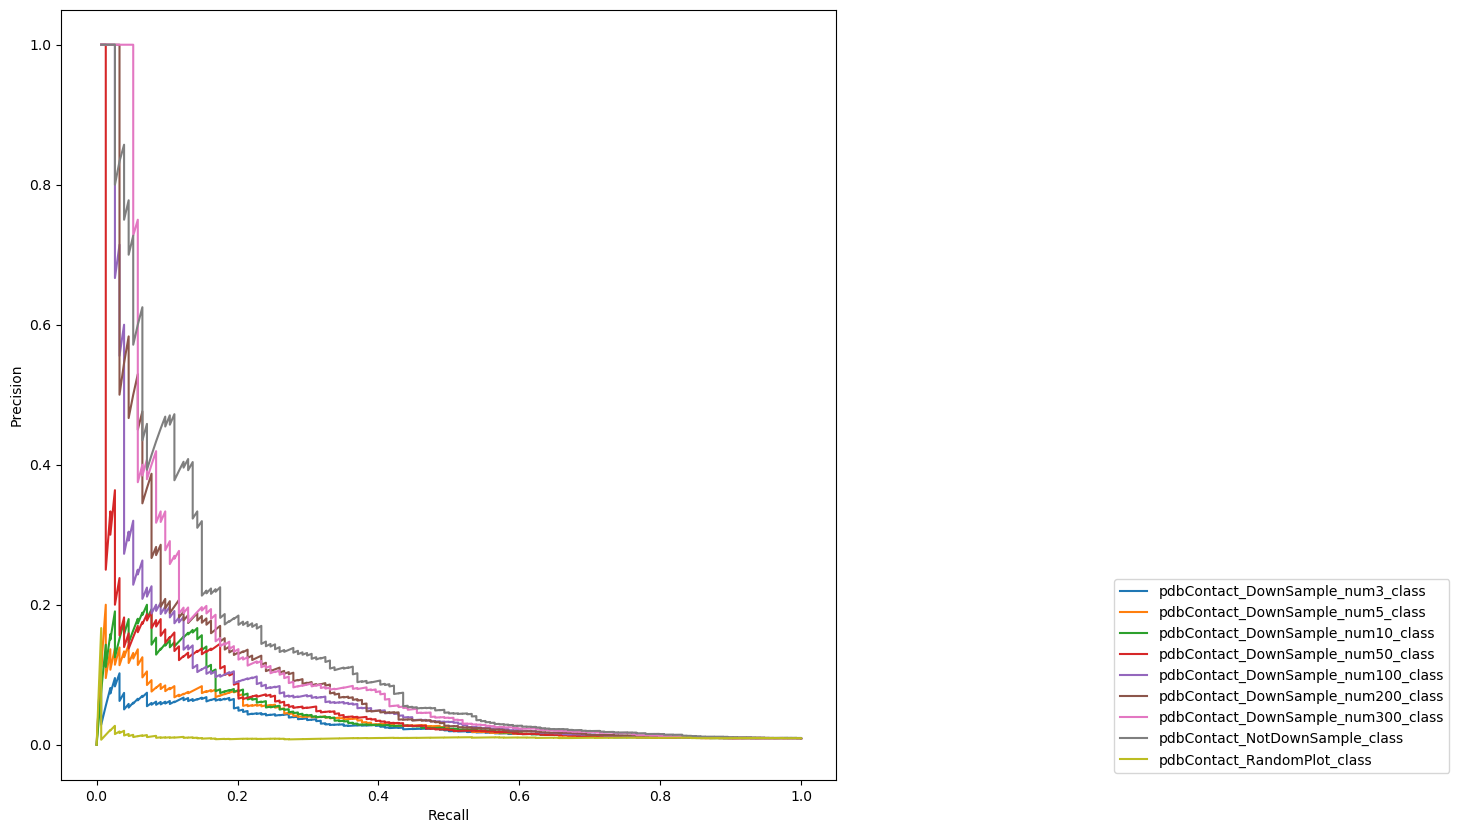

phylum
1224 511145 pdbContact_DownSample_num3_
1224 511145 pdbContact_DownSample_num5_
1224 511145 pdbContact_DownSample_num10_
1224 511145 pdbContact_DownSample_num50_
1224 511145 pdbContact_DownSample_num100_
1224 511145 pdbContact_DownSample_num200_
1224 511145 pdbContact_DownSample_num300_


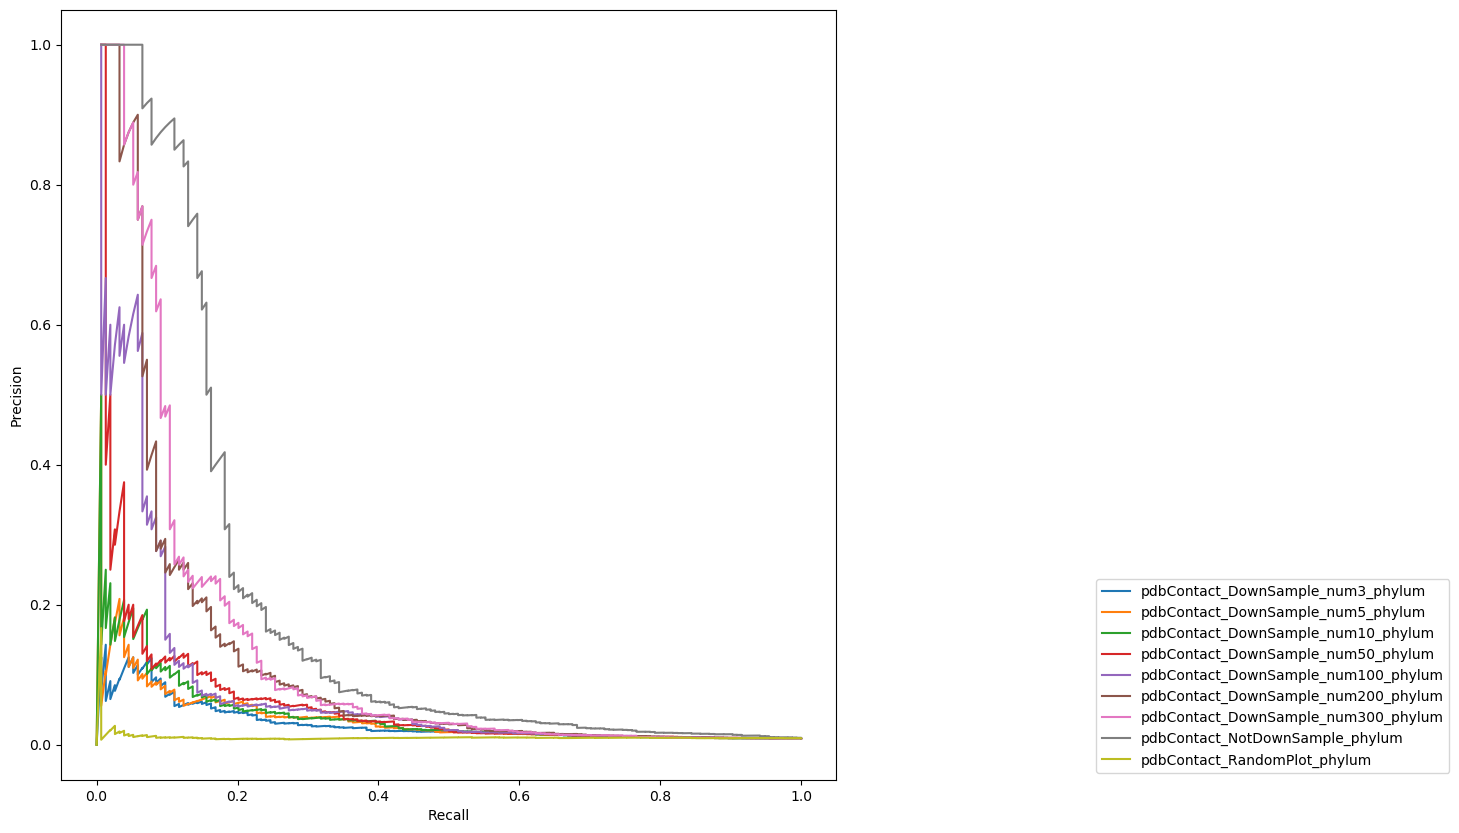

superkingdom
2 511145 pdbContact_DownSample_num3_
2 511145 pdbContact_DownSample_num5_
2 511145 pdbContact_DownSample_num10_
2 511145 pdbContact_DownSample_num50_
2 511145 pdbContact_DownSample_num100_
2 511145 pdbContact_DownSample_num200_
2 511145 pdbContact_DownSample_num300_


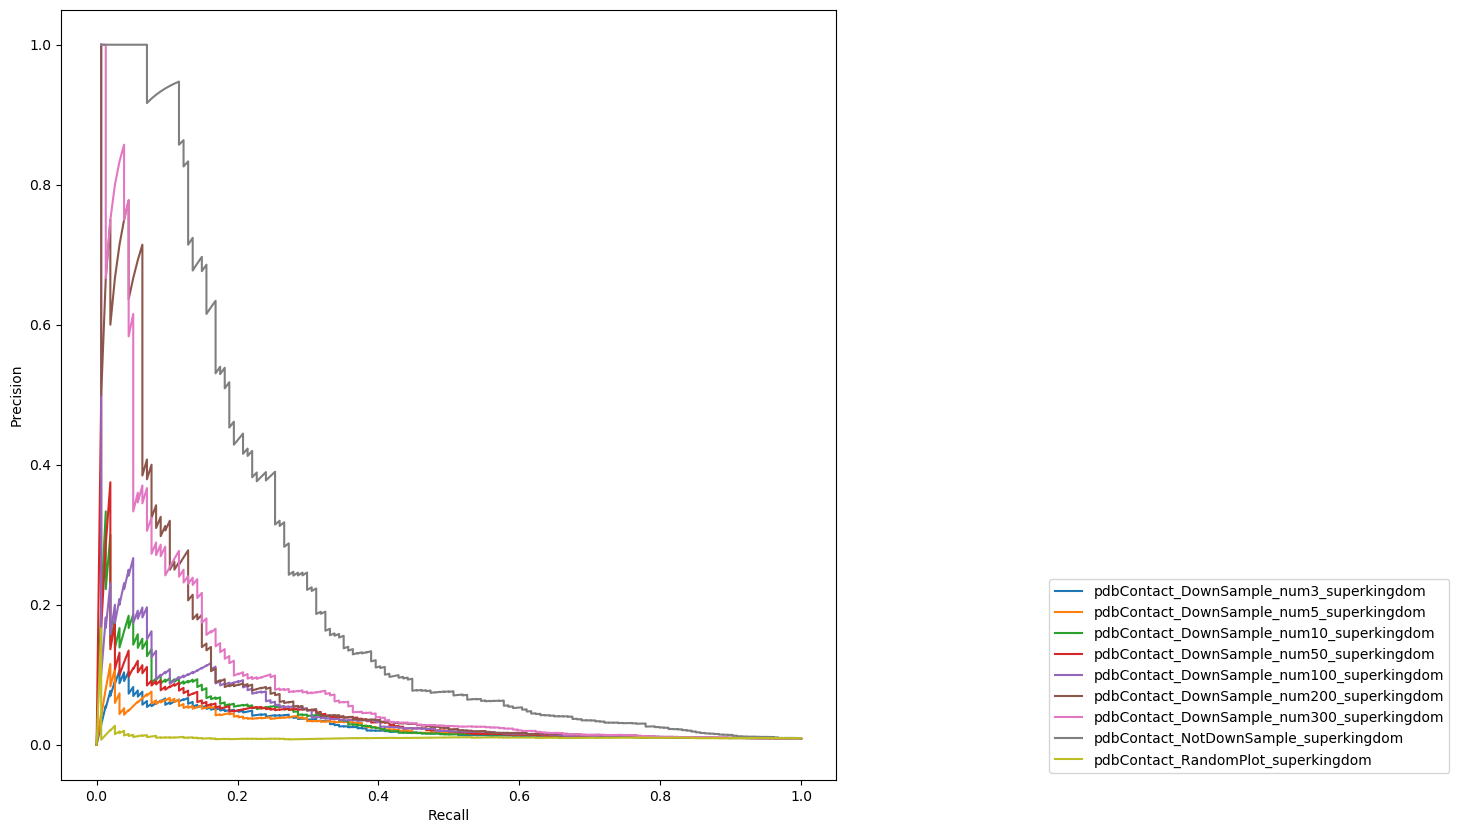

CPU times: user 1min, sys: 5.27 ms, total: 1min
Wall time: 1min


In [45]:
%%time 
count_label="rate"
step=1
zoom_thres=None

ifplot=True
return_metrics=True
plotType="PR"



tiny_randomnoise_range=1e-7 # noice DCA is roumnd to 4 floating digits 

phylum2spe_list=[('1236', '511145'),('1224', '511145'),("2", "511145"),]  

DownSample_strategy = "num"#"percent"
# DownSample_sizes=[3,5,10,50,100,200,300,500,600]
# DownSample_sizes_lable=[3, 10, 50, 100, 200, 300, 500,"NotDownSample"]

DownSample_sizes=[0,3,5,10,50,100,200,300,600] #[3,5,10,50,100,200,300]
DownSample_sizes_lable=["RandomPlot",3, 5,10, 50, 100, 200, 300,"NotDownSample"]
columns_names=["class","phylum","superkingdom"]


pdbContact_Taxa_PRAUC_table=pd.DataFrame(np.zeros((len(DownSample_sizes),3)),
                         index=DownSample_sizes_lable,
                         columns=columns_names)
pdbContact_Taxa_ROCAUC_table=pd.DataFrame(np.zeros((len(DownSample_sizes),3)),
                         index=DownSample_sizes_lable,
                         columns=columns_names)
pdbContact_medianDiff_table=pd.DataFrame(np.zeros((len(DownSample_sizes),3)),
                         index=DownSample_sizes_lable,
                         columns=columns_names)


for i,l in enumerate(phylum2spe_list): 
    
    column_name=columns_names[i]
    current_EggNOG_maxLevel,currentSpe_TaxID=l
    print(column_name)
    
    plt.figure(figsize=(10,10))
        
    for DownSample_size in DownSample_sizes[1:-1]:
        DownSamplePrefix="pdbContact_DownSample_"+DownSample_strategy+str(DownSample_size)+"_"
        print(current_EggNOG_maxLevel,currentSpe_TaxID, DownSamplePrefix)

        ROC_AUC,PR_AUC,F1_score_lastStep,ACC_lastStep=DCA_RocCurve(testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]["XtopDCAs"][pdb_contact_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict[column_name],0], 
                     testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]["YtopDCAs"][pdb_contact_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict[column_name]],
                     count_label=count_label,legend=DownSamplePrefix+f"{column_name}",
                     step=step,zoom_thres=zoom_thres,tiny_randomnoise_range=tiny_randomnoise_range,
                    return_metrics=return_metrics,ifplot=ifplot,
                    plotType=plotType)
        pdbContact_Taxa_PRAUC_table.loc[DownSample_size,column_name]=PR_AUC
        pdbContact_Taxa_ROCAUC_table.loc[DownSample_size,column_name]=ROC_AUC
        
        
        medianDiff=check_FrameColMedian_diff(testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]['updated_allPPI_allInfo_frame'].iloc[pdb_contact_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict[column_name],:])
        pdbContact_medianDiff_table.loc[DownSample_size,column_name]=medianDiff

    if column_name=="superkingdom":
        temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results
    elif column_name=="phylum":
        temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1224Spe511145_topDCAs_predicted_results
    elif column_name=="class":
        temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1236Spe511145_topDCAs_predicted_results
    
    
    ROC_AUC,PR_AUC,F1_score_lastStep,ACC_lastStep=DCA_RocCurve(temp_results["XtopDCAs"][pdb_contact_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx,0], 
                 temp_results["YtopDCAs"][pdb_contact_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx],
                 count_label=count_label,legend=f"pdbContact_NotDownSample_{column_name}",
                 step=step,zoom_thres=zoom_thres,tiny_randomnoise_range=tiny_randomnoise_range,
                 return_metrics=return_metrics,ifplot=ifplot,
                plotType=plotType)
    pdbContact_Taxa_PRAUC_table.loc["NotDownSample",column_name]=PR_AUC
    pdbContact_Taxa_ROCAUC_table.loc["NotDownSample",column_name]=ROC_AUC
    medianDiff=check_FrameColMedian_diff(temp_results['updated_allPPI_allInfo_frame'].iloc[pdb_contact_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx,:])
    pdbContact_medianDiff_table.loc["NotDownSample",column_name]=medianDiff
    
    ROC_AUC,PR_AUC,F1_score_lastStep,ACC_lastStep=DCA_RocCurve(temp_results["XtopDCAs"][pdb_contact_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx,0], 
                 temp_results["YtopDCAs"][pdb_contact_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx],
                 count_label=count_label,legend=f"pdbContact_RandomPlot_{column_name}",
                 step=step,zoom_thres=zoom_thres,tiny_randomnoise_range=tiny_randomnoise_range,
                 return_metrics=return_metrics,ifplot=ifplot,
                plotType=plotType,randomplot=True )
    pdbContact_Taxa_PRAUC_table.loc["RandomPlot",column_name]=PR_AUC
    pdbContact_Taxa_ROCAUC_table.loc["RandomPlot",column_name]=ROC_AUC

    
    plt.legend(bbox_to_anchor=(1.8,0), loc="lower right")
    #plt.legend().set_visible(False)
    plt.show()


# when step=1

In [46]:
pdbContact_medianDiff_table

,class,phylum,superkingdom
RandomPlot,0.00000,0.00000,0.00000
3,0.04520,0.03295,0.02105
5,0.12375,0.07220,0.05175
10,0.19020,0.14550,0.06630
50,0.31030,0.26335,0.20575
100,0.44965,0.28690,0.22090
200,0.32080,0.35215,0.24905
300,0.38555,0.31365,0.24480
NotDownSample,0.42550,0.42595,0.50335


class
1236 511145 pdbComplex_DownSample_num3_
1236 511145 pdbComplex_DownSample_num5_
1236 511145 pdbComplex_DownSample_num10_
1236 511145 pdbComplex_DownSample_num50_
1236 511145 pdbComplex_DownSample_num100_
1236 511145 pdbComplex_DownSample_num200_
1236 511145 pdbComplex_DownSample_num300_


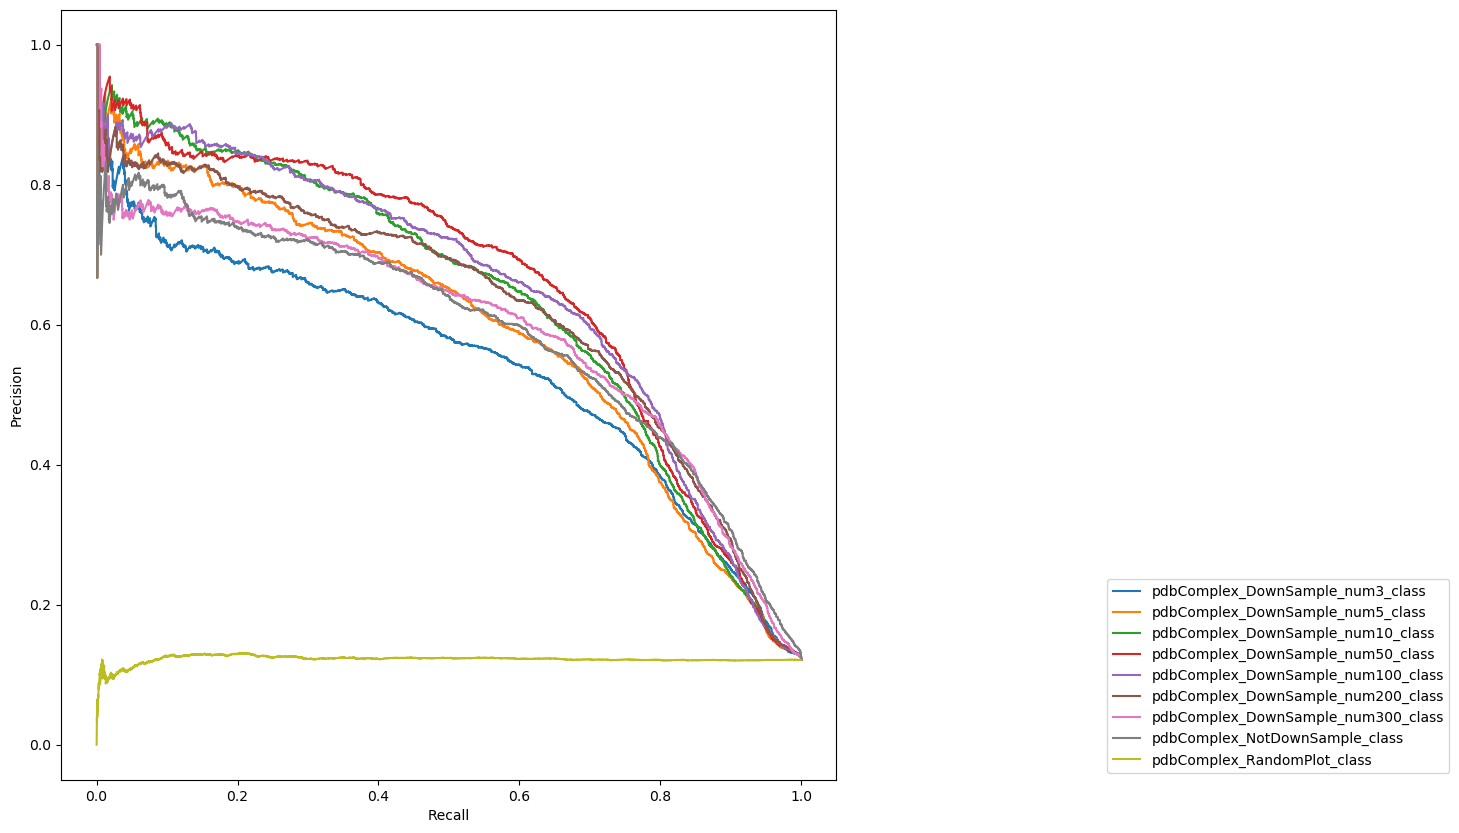

phylum
1224 511145 pdbComplex_DownSample_num3_
1224 511145 pdbComplex_DownSample_num5_
1224 511145 pdbComplex_DownSample_num10_
1224 511145 pdbComplex_DownSample_num50_
1224 511145 pdbComplex_DownSample_num100_
1224 511145 pdbComplex_DownSample_num200_
1224 511145 pdbComplex_DownSample_num300_


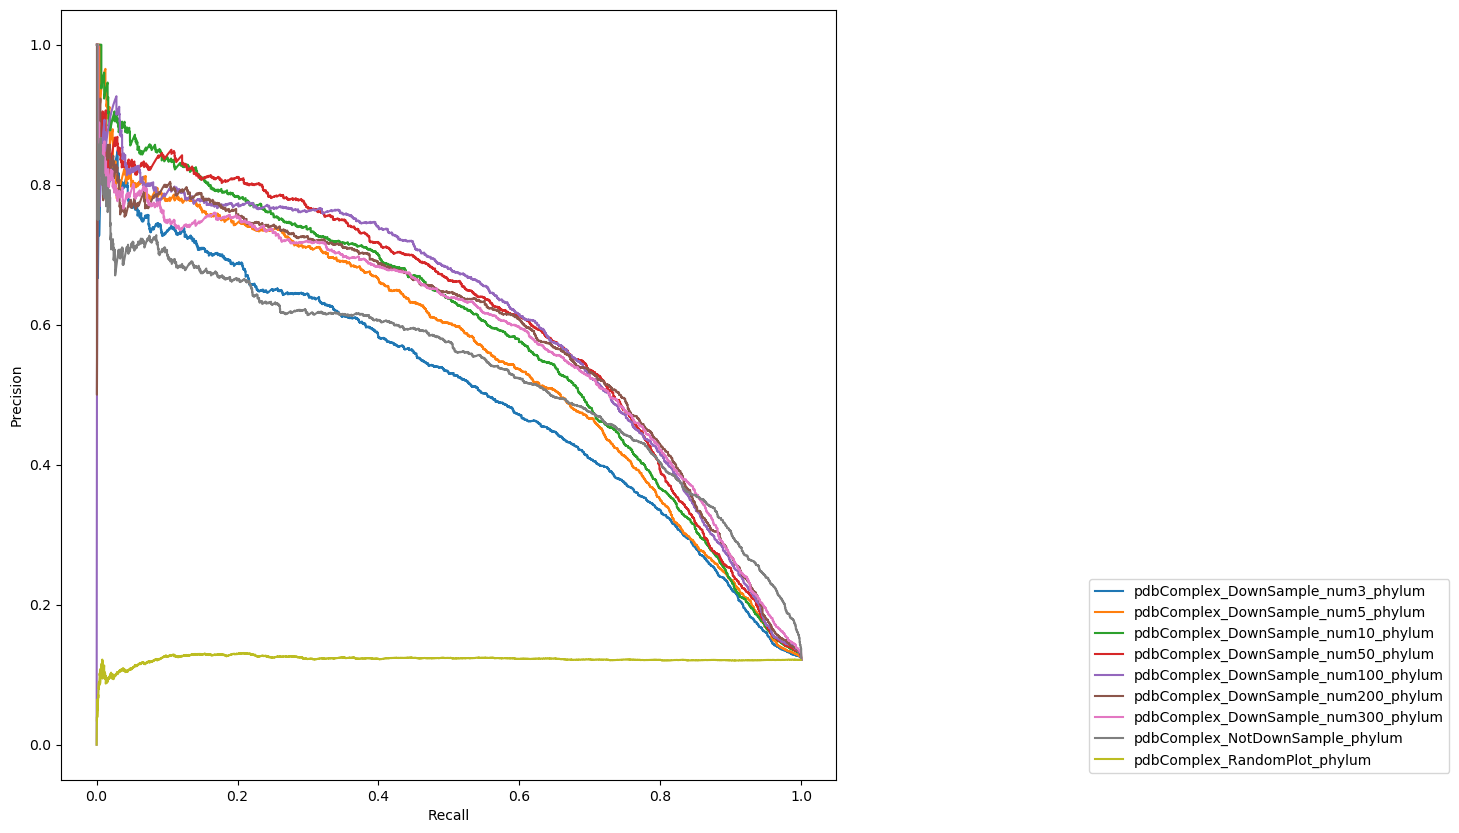

superkingdom
2 511145 pdbComplex_DownSample_num3_
2 511145 pdbComplex_DownSample_num5_
2 511145 pdbComplex_DownSample_num10_
2 511145 pdbComplex_DownSample_num50_
2 511145 pdbComplex_DownSample_num100_
2 511145 pdbComplex_DownSample_num200_
2 511145 pdbComplex_DownSample_num300_


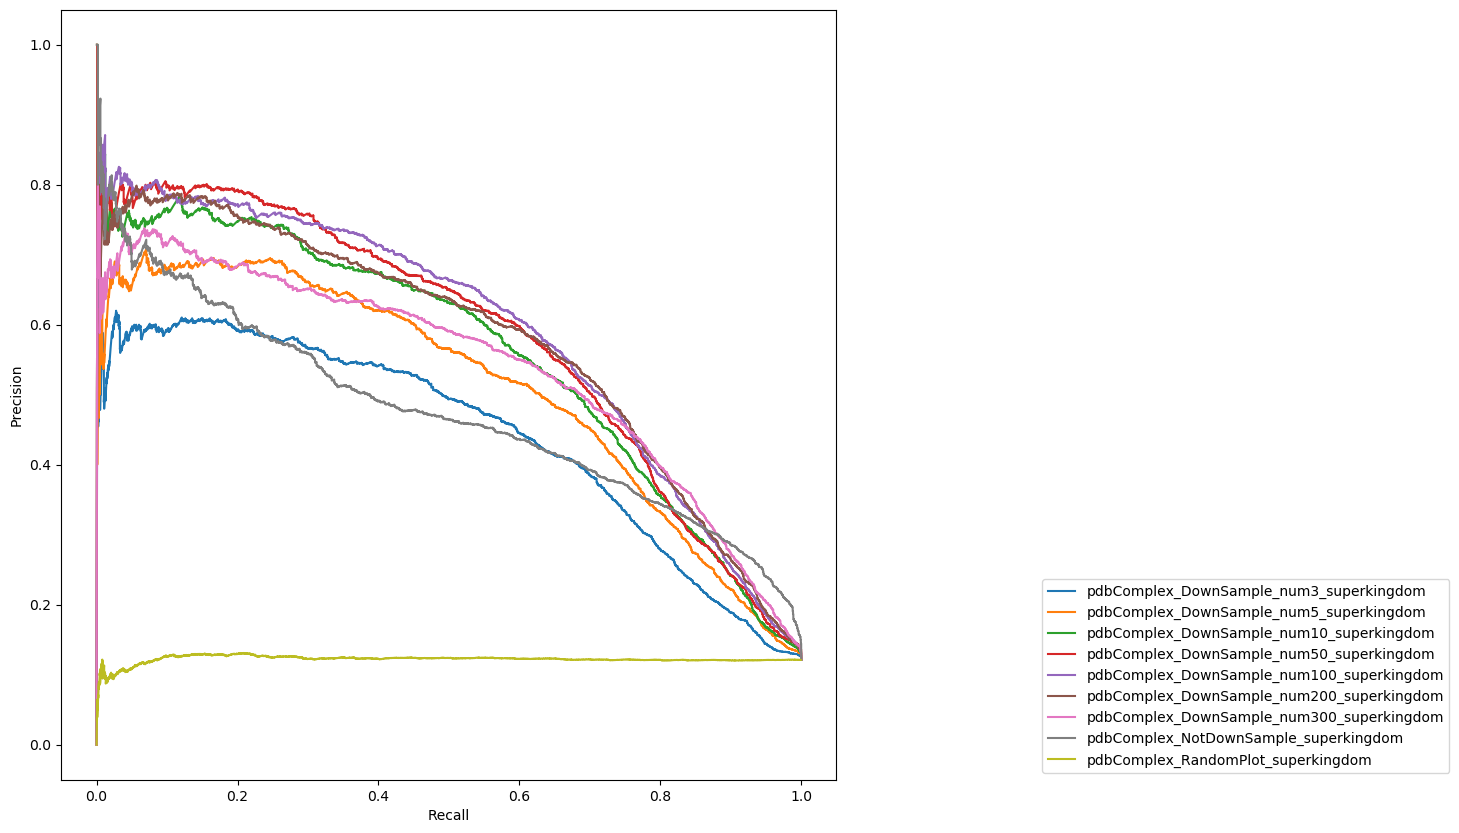

CPU times: user 1min 24s, sys: 28.5 ms, total: 1min 24s
Wall time: 1min 24s


In [47]:
%%time 
count_label="rate"
step=1
zoom_thres=None

ifplot=True
return_metrics=True
plotType="PR"



tiny_randomnoise_range=1e-7 # noice DCA is roumnd to 4 floating digits 

phylum2spe_list=[('1236', '511145'),('1224', '511145'),("2", "511145"),]  

DownSample_strategy = "num"#"percent"
# DownSample_sizes=[3,5,10,50,100,200,300,500,600]
# DownSample_sizes_lable=[3, 10, 50, 100, 200, 300, 500,"NotDownSample"]

DownSample_sizes=[0,3,5,10,50,100,200,300,600] #[3,5,10,50,100,200,300]
DownSample_sizes_lable=["RandomPlot",3,5, 10, 50, 100, 200, 300,"NotDownSample"]
columns_names=["class","phylum","superkingdom"]


pdbComplex_Taxa_PRAUC_table=pd.DataFrame(np.zeros((len(DownSample_sizes),3)),
                         index=DownSample_sizes_lable,
                         columns=columns_names)
pdbComplex_Taxa_ROCAUC_table=pd.DataFrame(np.zeros((len(DownSample_sizes),3)),
                         index=DownSample_sizes_lable,
                         columns=columns_names)

pdbComplex_medianDiff_table=pd.DataFrame(np.zeros((len(DownSample_sizes),3)),
                         index=DownSample_sizes_lable,
                         columns=columns_names)

for i,l in enumerate(phylum2spe_list): 
    
    column_name=columns_names[i]
    current_EggNOG_maxLevel,currentSpe_TaxID=l
    print(column_name)
    
    plt.figure(figsize=(10,10))
        
    for DownSample_size in DownSample_sizes[1:-1]:
        DownSamplePrefix="pdbComplex_DownSample_"+DownSample_strategy+str(DownSample_size)+"_"
        print(current_EggNOG_maxLevel,currentSpe_TaxID, DownSamplePrefix)

        ROC_AUC,PR_AUC,F1_score_lastStep,ACC_lastStep=DCA_RocCurve(testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]["XtopDCAs"][pdb_complex_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict[column_name],0], 
                     testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]["YtopDCAs"][pdb_complex_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict[column_name]],
                     count_label=count_label,legend=DownSamplePrefix+f"{column_name}",
                     step=step,zoom_thres=zoom_thres,tiny_randomnoise_range=tiny_randomnoise_range,
                    return_metrics=return_metrics,ifplot=ifplot,
                    plotType=plotType)
        pdbComplex_Taxa_PRAUC_table.loc[DownSample_size,column_name]=PR_AUC
        pdbComplex_Taxa_ROCAUC_table.loc[DownSample_size,column_name]=ROC_AUC
        
        medianDiff=check_FrameColMedian_diff(testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]['updated_allPPI_allInfo_frame'].iloc[pdb_complex_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict[column_name],:])
        pdbComplex_medianDiff_table.loc[DownSample_size,column_name]=medianDiff
        
    if column_name=="superkingdom":
        temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results
    elif column_name=="phylum":
        temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1224Spe511145_topDCAs_predicted_results
    elif column_name=="class":
        temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1236Spe511145_topDCAs_predicted_results
    
    
    ROC_AUC,PR_AUC,F1_score_lastStep,ACC_lastStep=DCA_RocCurve(temp_results["XtopDCAs"][pdb_complex_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx,0], 
                 temp_results["YtopDCAs"][pdb_complex_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx],
                 count_label=count_label,legend=f"pdbComplex_NotDownSample_{column_name}",
                 step=step,zoom_thres=zoom_thres,tiny_randomnoise_range=tiny_randomnoise_range,
                 return_metrics=return_metrics,ifplot=ifplot,
                plotType=plotType)
    pdbComplex_Taxa_PRAUC_table.loc["NotDownSample",column_name]=PR_AUC
    pdbComplex_Taxa_ROCAUC_table.loc["NotDownSample",column_name]=ROC_AUC
    medianDiff=check_FrameColMedian_diff(temp_results['updated_allPPI_allInfo_frame'].iloc[pdb_complex_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx,:])
    pdbComplex_medianDiff_table.loc["NotDownSample",column_name]=medianDiff
    
    ROC_AUC,PR_AUC,F1_score_lastStep,ACC_lastStep=DCA_RocCurve(temp_results["XtopDCAs"][pdb_complex_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx,0], 
                 temp_results["YtopDCAs"][pdb_complex_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx],
                 count_label=count_label,legend=f"pdbComplex_RandomPlot_{column_name}",
                 step=step,zoom_thres=zoom_thres,tiny_randomnoise_range=tiny_randomnoise_range,
                 return_metrics=return_metrics,ifplot=ifplot,
                plotType=plotType,
                randomplot=True)
    pdbComplex_Taxa_PRAUC_table.loc["RandomPlot",column_name]=PR_AUC
    pdbComplex_Taxa_ROCAUC_table.loc["RandomPlot",column_name]=ROC_AUC


    plt.legend(bbox_to_anchor=(1.8,0), loc="lower right")
    #plt.legend().set_visible(False)
    plt.show()


# when step=1

###  retired figure 3b

In [48]:
pdbContact_Taxa_PRAUC_table

,class,phylum,superkingdom
RandomPlot,0.0104,0.0104,0.0104
3,0.0285,0.0295,0.0267
5,0.0363,0.0353,0.0264
10,0.0453,0.0405,0.0390
50,0.0555,0.0540,0.0379
100,0.0798,0.0727,0.0450
200,0.0990,0.1119,0.0897
300,0.1166,0.1272,0.0952
NotDownSample,0.1340,0.1923,0.2348


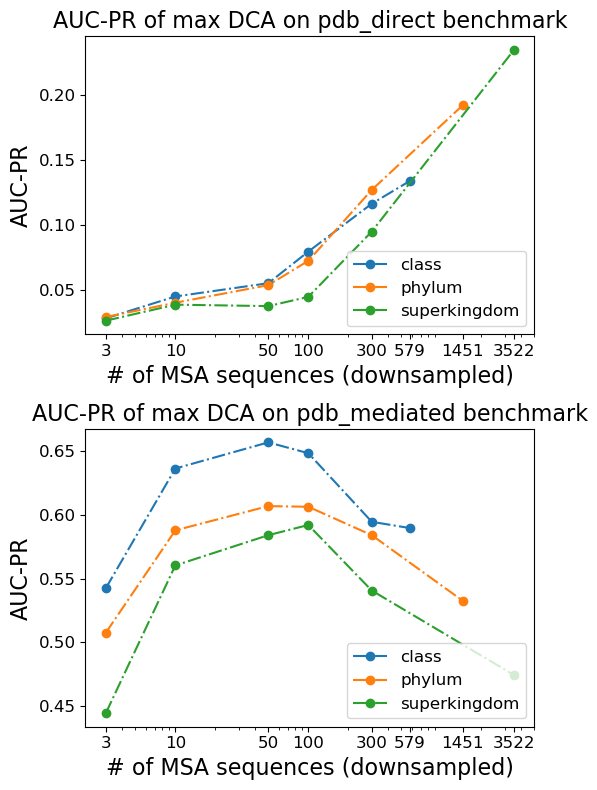

CPU times: user 516 ms, sys: 212 ms, total: 728 ms
Wall time: 489 ms


In [49]:
%%time 

DownSample_sizes=[3,10,50,100,300,600] #[3,5,10,50,100,200,300]
DownSample_sizes_lable=[3,10, 50, 100, 300,"NotDownSample"]


class_DownSample_sizes=DownSample_sizes[:-1]+[579]
phylum_DownSample_sizes=DownSample_sizes[:-1]+[1451]
superkingdom_DownSample_sizes=DownSample_sizes[:-1]+[3522]


fig2 = plt.figure(figsize=(6,8)) #plt.figure(figsize=(15,6)) figsize=(15,15)

ax1 = plt.subplot(2,1,1) #plt.subplot(1,3,1)
ax1.plot(class_DownSample_sizes,list(pdbContact_Taxa_PRAUC_table.loc[DownSample_sizes_lable,"class"]),label="class",
        linestyle="-.",marker="o")
ax1.plot(phylum_DownSample_sizes,list(pdbContact_Taxa_PRAUC_table.loc[DownSample_sizes_lable,"phylum"]),label="phylum",
        linestyle="-.",marker="o")
ax1.plot(superkingdom_DownSample_sizes,list(pdbContact_Taxa_PRAUC_table.loc[DownSample_sizes_lable,"superkingdom"]),label="superkingdom",
        linestyle="-.",marker="o")
# ax1.set_xticks(DownSample_sizes,DownSample_sizes_lable,fontsize=7,rotation=45,)
ax1.set_title("AUC-PR of max DCA on pdb_direct benchmark",fontsize=16)
#ax1.set_title("pdb_direct",loc='center',fontsize=10)
ax1.set_xlabel("# of MSA sequences (downsampled)",fontsize=16)#,loc='center'
ax1.set_ylabel("AUC-PR",fontsize=16)
ax1.set_xscale("log")
# ax1.set_xticks(DownSample_sizes[:-1]+[579,1451,3522],
#                DownSample_sizes[:-1]+[579,1451,3522],
#                # rotation=40,
#               )
ax1.set_xticks(DownSample_sizes[:-1]+[579,1451,3522],
              )
ax1.set_xticklabels(DownSample_sizes[:-1]+[579,1451,3522],
              )
plt.xticks(fontsize=12)# compare with ax2.set_xticks, this one dont need to give exact ticks position
plt.yticks(fontsize=12)
ax1.legend( loc="lower right",fontsize=12)



ax2 = plt.subplot(2,1,2)
ax2.plot(class_DownSample_sizes,list(pdbComplex_Taxa_PRAUC_table.loc[DownSample_sizes_lable,"class"]),label="class",
        linestyle="-.",marker="o")
ax2.plot(phylum_DownSample_sizes,list(pdbComplex_Taxa_PRAUC_table.loc[DownSample_sizes_lable,"phylum"]),label="phylum",
        linestyle="-.",marker="o")
ax2.plot(superkingdom_DownSample_sizes,list(pdbComplex_Taxa_PRAUC_table.loc[DownSample_sizes_lable,"superkingdom"]),label="superkingdom",
        linestyle="-.",marker="o")
# ax2.set_xticks(DownSample_sizes,DownSample_sizes_lable,fontsize=7,rotation=45,)
ax2.set_title("AUC-PR of max DCA on pdb_mediated benchmark",fontsize=16)
ax2.set_xlabel("# of MSA sequences (downsampled)",fontsize=16) #,loc='center'
ax2.set_ylabel("AUC-PR",fontsize=16)
ax2.set_xscale("log")
# ax2.set_xticks(DownSample_sizes[:-1]+[579,1451,3522],
#                DownSample_sizes[:-1]+[579,1451,3522],
#                # rotation=40,
#               )
ax2.set_xticks(DownSample_sizes[:-1]+[579,1451,3522],
               # rotation=40,
              )
ax2.set_xticklabels(DownSample_sizes[:-1]+[579,1451,3522],
               # rotation=40,
              )
plt.xticks(fontsize=12)# compare with ax2.set_xticks, this one dont need to give exact ticks position
plt.yticks(fontsize=12)
# ax2.set_ylabel("AUC-PR",loc='center',fontsize=10)

#plt.legend(bbox_to_anchor=(1.6,0),loc="lower right")ls
ax2.legend(loc="lower right",fontsize=12)



fig2.tight_layout()

plt.show()

fig2.savefig("/mnt/mnemo5/tao/temp_figures/Fig2.pdf", dpi=600)

# same as above section but  with samePos2NegRatio for pdb_direct and pdb_mediated benchmark 

## compare between different taxnomimic order

In [51]:
testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1236Spe511145_topDCAs_predicted_results['updated_allPPI_allInfo_frame']

,STRING_ID1,STRING_ID2,benchmark_status,maxBetDCA_score,maxBetMI_score,len1,len2,LR_onesProb,RF_onesProb
0,511145.b0014,511145.b0055,P,1.2790,0.0868,638,270,0.142476,0.102693
1,511145.b0014,511145.b0095,P,1.1044,0.1006,638,382,0.195483,0.228056
2,511145.b0014,511145.b0436,P,1.1697,0.0821,638,431,0.111612,0.075258
3,511145.b0014,511145.b2528,P,1.4431,0.0636,638,107,0.219838,0.213453
4,511145.b0014,511145.b2614,P,1.1596,0.1208,638,193,0.228379,0.243970
...,...,...,...,...,...,...,...,...,...
19664,511145.b4207,511145.b4473,N,1.0079,0.0547,206,363,0.044158,0.071358
19665,511145.b4221,511145.b4355,N,0.4546,0.0689,1245,344,0.004178,0.048297
19666,511145.b4221,511145.b4389,N,0.5271,0.0968,1245,455,0.008464,0.044512
19667,511145.b4245,511145.b4355,N,0.7354,0.0367,305,344,0.016801,0.043915


In [52]:
pos_lable="pdb_contact"

_,samePos2NegRatio_pdb_contact_NotDownSampleSamePPs_STRING115EggNog1236Spe511145_idx=get_filter_pdbBenchmark(testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1236Spe511145_topDCAs_predicted_results['updated_allPPI_allInfo_frame'],
                                                                       pos_lable=pos_lable,
                                                                        downsample_Ratio=1116,
                                                                       )


_,samePos2NegRatio_pdb_contact_NotDownSampleSamePPs_STRING115EggNog1224Spe511145_idx=get_filter_pdbBenchmark(testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1224Spe511145_topDCAs_predicted_results['updated_allPPI_allInfo_frame'],
                                                                       pos_lable=pos_lable,
                                                                        downsample_Ratio=1116,)


_,samePos2NegRatio_pdb_contact_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx=get_filter_pdbBenchmark(testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results['updated_allPPI_allInfo_frame'],
                                                                       pos_lable=pos_lable,
                                                                        downsample_Ratio=1116,)



pos number: 154
neg number  16249
(19669, 10) 1270
pos number: 154
neg number  16249
(19669, 10) 1270


/mnt/mnemo5/tao/anaconda3/envs/py38_notebook/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


pos number: 154
neg number  16249
(19669, 10) 1270


In [53]:
pos_lable="pdb_complex"

_,samePos2NegRatio_pdb_complex_NotDownSampleSamePPs_STRING115EggNog1236Spe511145_idx=get_filter_pdbBenchmark(testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1236Spe511145_topDCAs_predicted_results['updated_allPPI_allInfo_frame'],
                                                                       pos_lable=pos_lable,
                                                                            downsample_Ratio=None)


_,samePos2NegRatio_pdb_complex_NotDownSampleSamePPs_STRING115EggNog1224Spe511145_idx=get_filter_pdbBenchmark(testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1224Spe511145_topDCAs_predicted_results['updated_allPPI_allInfo_frame'],
                                                                       pos_lable=pos_lable,
                                                                        downsample_Ratio=None)


_,samePos2NegRatio_pdb_complex_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx=get_filter_pdbBenchmark(testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results['updated_allPPI_allInfo_frame'],
                                                                       pos_lable=pos_lable,
                                                                    downsample_Ratio=None)



/mnt/mnemo5/tao/anaconda3/envs/py38_notebook/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/mnemo5/tao/anaconda3/envs/py38_notebook/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


pos number: 2242
neg number  16249
(19669, 10) 18491
pos number: 2242
neg number  16249
(19669, 10) 18491
pos number: 2242
neg number  16249
(19669, 10) 18491


## compare between different downsampling numbers for all taxonomic levels 

In [54]:
%%time

phylum2spe_list=[("2", "511145"),] 

DownSample_strategy = "num"#"percent"
DownSample_sizes=[3,5,10,50,100,200,300,600] #[3,5,10,50,100,200,300]


columns_names=["class","phylum","superkingdom"]

samePos2NegRatio_pdb_contact_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict=dict()
samePos2NegRatio_pdb_complex_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict=dict()



for column_name in columns_names:
    print(column_name)
    for i,DownSample_size in enumerate(DownSample_sizes[:-1]):
        for j,l in enumerate(phylum2spe_list): 
            current_EggNOG_maxLevel,currentSpe_TaxID=l 
            DownSamplePrefix="DownSample_"+DownSample_strategy+str(DownSample_size)+"_"

            print(current_EggNOG_maxLevel,currentSpe_TaxID, DownSamplePrefix)

            _,samePos2NegRatio_pdb_contact_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict[column_name]=get_filter_pdbBenchmark(testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]['updated_allPPI_allInfo_frame'],
                                                                           pos_lable="pdb_contact",
                                                                            downsample_Ratio=1116)
            _,samePos2NegRatio_pdb_complex_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict[column_name]=get_filter_pdbBenchmark(testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]['updated_allPPI_allInfo_frame'],
                                                                           pos_lable="pdb_complex",
                                                                            downsample_Ratio=None)






# CPU times: user 1min 30s, sys: 140 ms, total: 1min 30s
# Wall time: 1min 30s  
# actullly for loop not necessary , as they are all should be same

class
2 511145 DownSample_num3_
pos number: 154
neg number  16249
(19669, 10) 1270
pos number: 2242
neg number  16249
(19669, 10) 18491
2 511145 DownSample_num5_
pos number: 154
neg number  16249
(19669, 10) 1270
pos number: 2242
neg number  16249
(19669, 10) 18491
2 511145 DownSample_num10_
pos number: 154
neg number  16249
(19669, 10) 1270
pos number: 2242
neg number  16249
(19669, 10) 18491
2 511145 DownSample_num50_
pos number: 154
neg number  16249
(19669, 10) 1270
pos number: 2242
neg number  16249
(19669, 10) 18491
2 511145 DownSample_num100_
pos number: 154
neg number  16249
(19669, 10) 1270
pos number: 2242
neg number  16249
(19669, 10) 18491
2 511145 DownSample_num200_
pos number: 154
neg number  16249
(19669, 10) 1270
pos number: 2242
neg number  16249
(19669, 10) 18491
2 511145 DownSample_num300_
pos number: 154
neg number  16249
(19669, 10) 1270
pos number: 2242
neg number  16249
(19669, 10) 18491
phylum
2 511145 DownSample_num3_
pos number: 154
neg number  16249
(19669, 1

class
1236 511145 pdbContact_DownSample_num3_
1236 511145 pdbContact_DownSample_num5_
1236 511145 pdbContact_DownSample_num10_
1236 511145 pdbContact_DownSample_num50_
1236 511145 pdbContact_DownSample_num100_
1236 511145 pdbContact_DownSample_num200_
1236 511145 pdbContact_DownSample_num300_


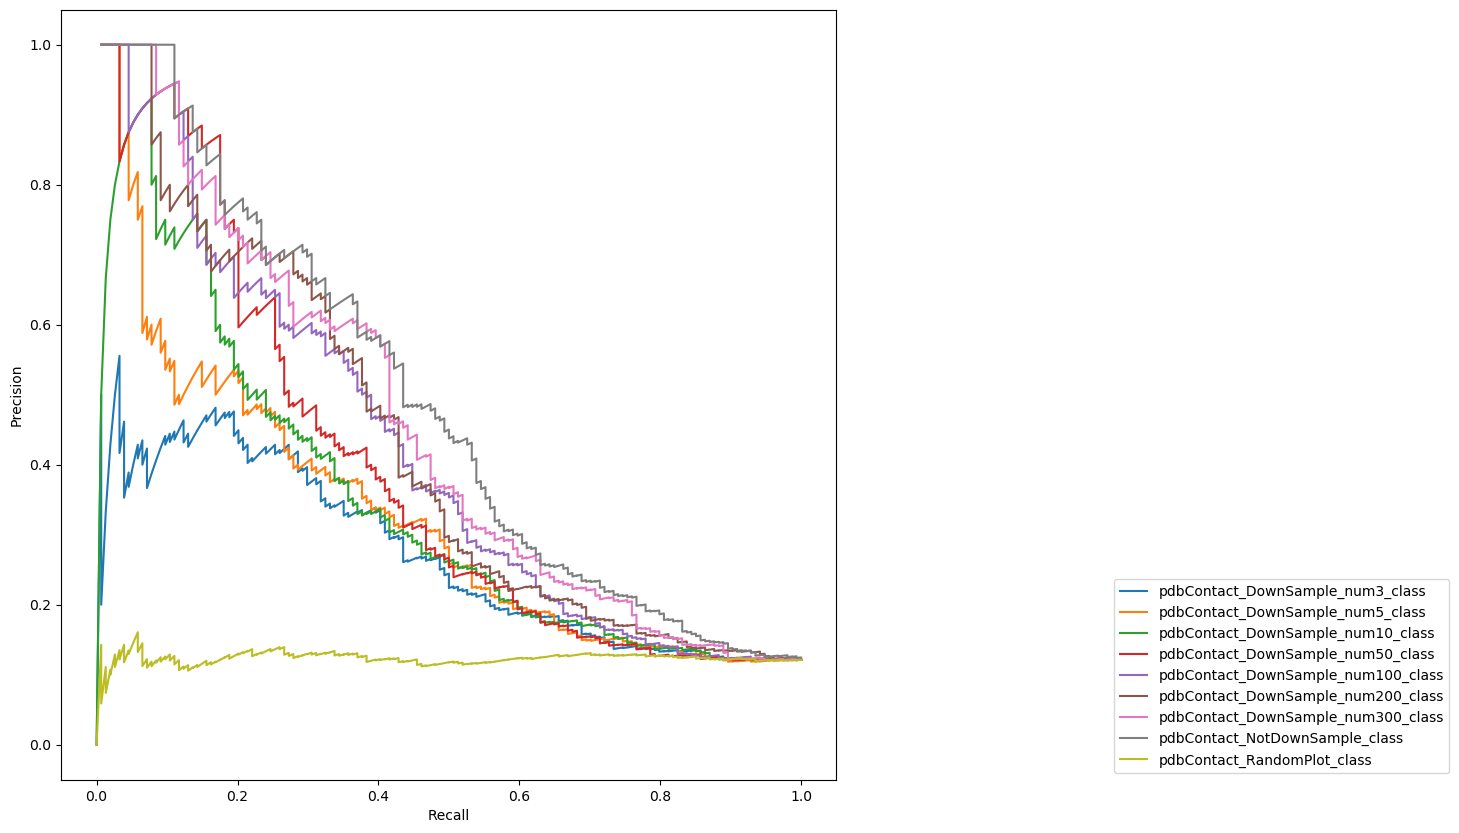

phylum
1224 511145 pdbContact_DownSample_num3_
1224 511145 pdbContact_DownSample_num5_
1224 511145 pdbContact_DownSample_num10_
1224 511145 pdbContact_DownSample_num50_
1224 511145 pdbContact_DownSample_num100_
1224 511145 pdbContact_DownSample_num200_
1224 511145 pdbContact_DownSample_num300_


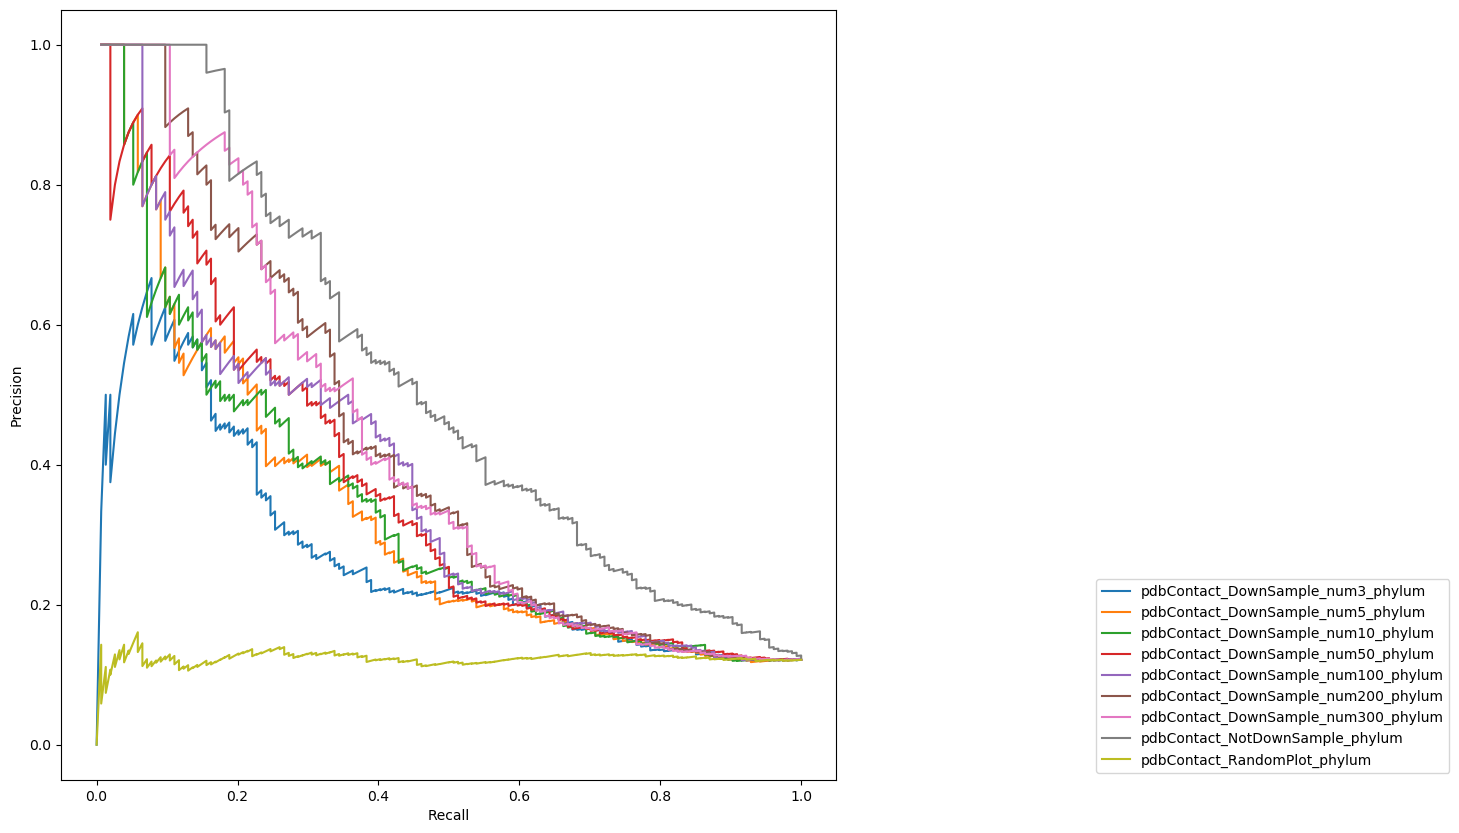

superkingdom
2 511145 pdbContact_DownSample_num3_
2 511145 pdbContact_DownSample_num5_
2 511145 pdbContact_DownSample_num10_
2 511145 pdbContact_DownSample_num50_
2 511145 pdbContact_DownSample_num100_
2 511145 pdbContact_DownSample_num200_
2 511145 pdbContact_DownSample_num300_


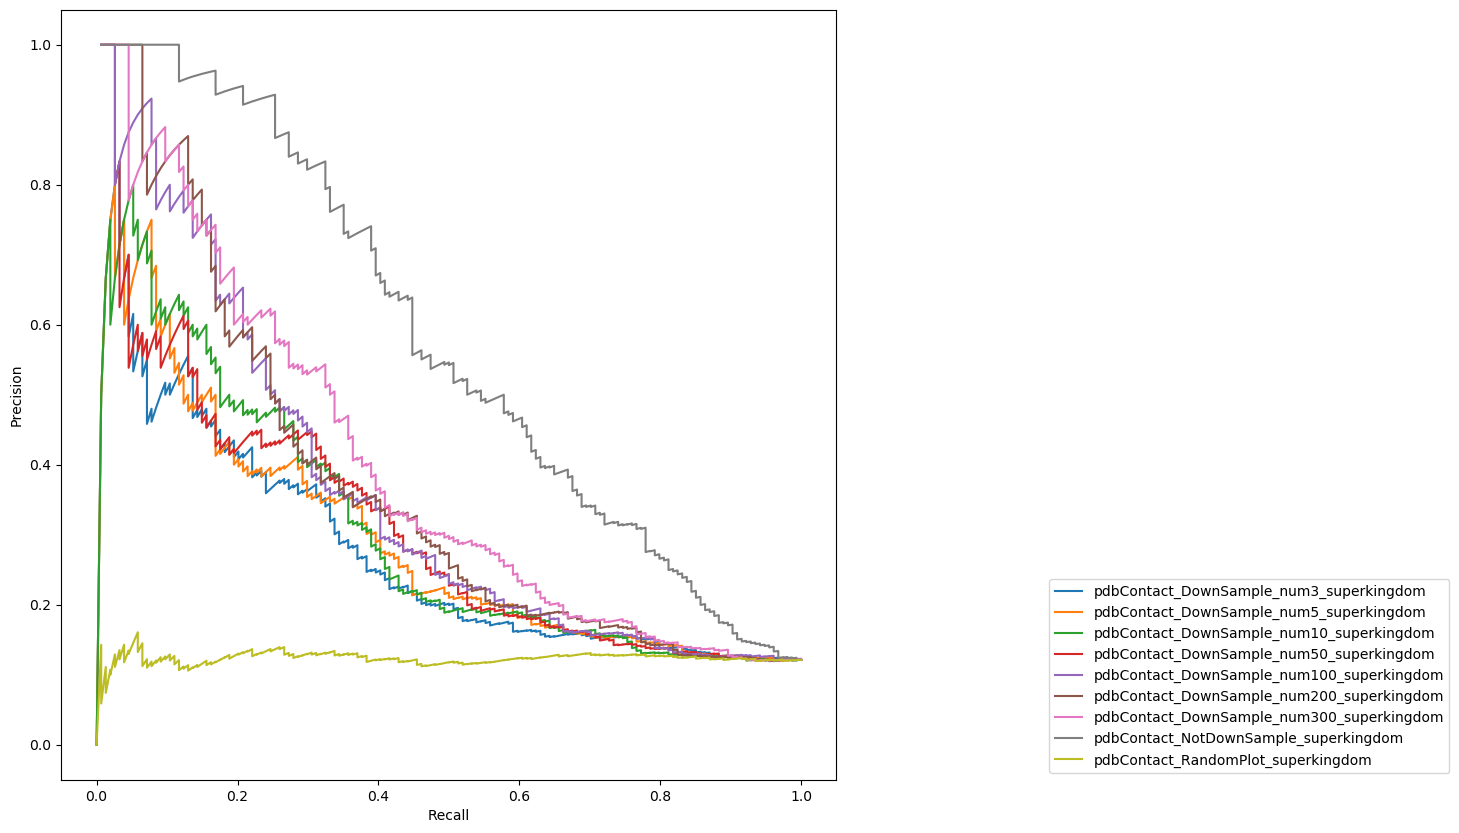

CPU times: user 1.24 s, sys: 33.2 ms, total: 1.27 s
Wall time: 1.27 s


In [55]:
%%time 
count_label="rate"
step=1
zoom_thres=None

ifplot=True
return_metrics=True
plotType="PR"



tiny_randomnoise_range=1e-7 # noice DCA is roumnd to 4 floating digits 

phylum2spe_list=[('1236', '511145'),('1224', '511145'),("2", "511145"),]  

DownSample_strategy = "num"#"percent"
# DownSample_sizes=[3,5,10,50,100,200,300,500,600]
# DownSample_sizes_lable=[3, 10, 50, 100, 200, 300, 500,"NotDownSample"]

DownSample_sizes=[0,3,5,10,50,100,200,300,600] #[3,5,10,50,100,200,300]
DownSample_sizes_lable=["RandomPlot",3, 5,10, 50, 100, 200, 300,"NotDownSample"]
columns_names=["class","phylum","superkingdom"]


samePos2NegRatio_pdbContact_Taxa_PRAUC_table=pd.DataFrame(np.zeros((len(DownSample_sizes),3)),
                         index=DownSample_sizes_lable,
                         columns=columns_names)
samePos2NegRatio_pdbContact_Taxa_ROCAUC_table=pd.DataFrame(np.zeros((len(DownSample_sizes),3)),
                         index=DownSample_sizes_lable,
                         columns=columns_names)
samePos2NegRatio_pdbContact_medianDiff_table=pd.DataFrame(np.zeros((len(DownSample_sizes),3)),
                         index=DownSample_sizes_lable,
                         columns=columns_names)


for i,l in enumerate(phylum2spe_list): 
    
    column_name=columns_names[i]
    current_EggNOG_maxLevel,currentSpe_TaxID=l
    print(column_name)
    
    plt.figure(figsize=(10,10))
        
    for DownSample_size in DownSample_sizes[1:-1]:
        DownSamplePrefix="pdbContact_DownSample_"+DownSample_strategy+str(DownSample_size)+"_"
        print(current_EggNOG_maxLevel,currentSpe_TaxID, DownSamplePrefix)

        ROC_AUC,PR_AUC,F1_score_lastStep,ACC_lastStep=DCA_RocCurve(testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]["XtopDCAs"][samePos2NegRatio_pdb_contact_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict[column_name],0], 
                     testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]["YtopDCAs"][samePos2NegRatio_pdb_contact_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict[column_name]],
                     count_label=count_label,legend=DownSamplePrefix+f"{column_name}",
                     step=step,zoom_thres=zoom_thres,tiny_randomnoise_range=tiny_randomnoise_range,
                    return_metrics=return_metrics,ifplot=ifplot,
                    plotType=plotType)
        samePos2NegRatio_pdbContact_Taxa_PRAUC_table.loc[DownSample_size,column_name]=PR_AUC
        samePos2NegRatio_pdbContact_Taxa_ROCAUC_table.loc[DownSample_size,column_name]=ROC_AUC
        
        
        medianDiff=check_FrameColMedian_diff(testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]['updated_allPPI_allInfo_frame'].iloc[samePos2NegRatio_pdb_contact_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict[column_name],:])
        samePos2NegRatio_pdbContact_medianDiff_table.loc[DownSample_size,column_name]=medianDiff

    if column_name=="superkingdom":
        temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results
    elif column_name=="phylum":
        temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1224Spe511145_topDCAs_predicted_results
    elif column_name=="class":
        temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1236Spe511145_topDCAs_predicted_results
    
    
    ROC_AUC,PR_AUC,F1_score_lastStep,ACC_lastStep=DCA_RocCurve(temp_results["XtopDCAs"][samePos2NegRatio_pdb_contact_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx,0], 
                 temp_results["YtopDCAs"][samePos2NegRatio_pdb_contact_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx],
                 count_label=count_label,legend=f"pdbContact_NotDownSample_{column_name}",
                 step=step,zoom_thres=zoom_thres,tiny_randomnoise_range=tiny_randomnoise_range,
                 return_metrics=return_metrics,ifplot=ifplot,
                plotType=plotType)
    samePos2NegRatio_pdbContact_Taxa_PRAUC_table.loc["NotDownSample",column_name]=PR_AUC
    samePos2NegRatio_pdbContact_Taxa_ROCAUC_table.loc["NotDownSample",column_name]=ROC_AUC
    medianDiff=check_FrameColMedian_diff(temp_results['updated_allPPI_allInfo_frame'].iloc[samePos2NegRatio_pdb_contact_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx,:])
    samePos2NegRatio_pdbContact_medianDiff_table.loc["NotDownSample",column_name]=medianDiff
    
    ROC_AUC,PR_AUC,F1_score_lastStep,ACC_lastStep=DCA_RocCurve(temp_results["XtopDCAs"][samePos2NegRatio_pdb_contact_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx,0], 
                 temp_results["YtopDCAs"][samePos2NegRatio_pdb_contact_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx],
                 count_label=count_label,legend=f"pdbContact_RandomPlot_{column_name}",
                 step=step,zoom_thres=zoom_thres,tiny_randomnoise_range=tiny_randomnoise_range,
                 return_metrics=return_metrics,ifplot=ifplot,
                plotType=plotType,randomplot=True )
    samePos2NegRatio_pdbContact_Taxa_PRAUC_table.loc["RandomPlot",column_name]=PR_AUC
    samePos2NegRatio_pdbContact_Taxa_ROCAUC_table.loc["RandomPlot",column_name]=ROC_AUC

    
    plt.legend(bbox_to_anchor=(1.8,0), loc="lower right")
    #plt.legend().set_visible(False)
    plt.show()


# when step=1

In [56]:
samePos2NegRatio_pdbContact_Taxa_PRAUC_table

,class,phylum,superkingdom
RandomPlot,0.1231,0.1231,0.1231
3,0.2659,0.2668,0.2696
5,0.3190,0.3218,0.2882
10,0.3413,0.3258,0.3014
50,0.3832,0.3565,0.3013
100,0.4140,0.3665,0.3511
200,0.4198,0.4154,0.3611
300,0.4466,0.4150,0.3868
NotDownSample,0.4776,0.5112,0.5700


class
1236 511145 pdbComplex_DownSample_num3_
1236 511145 pdbComplex_DownSample_num5_
1236 511145 pdbComplex_DownSample_num10_
1236 511145 pdbComplex_DownSample_num50_
1236 511145 pdbComplex_DownSample_num100_
1236 511145 pdbComplex_DownSample_num200_
1236 511145 pdbComplex_DownSample_num300_


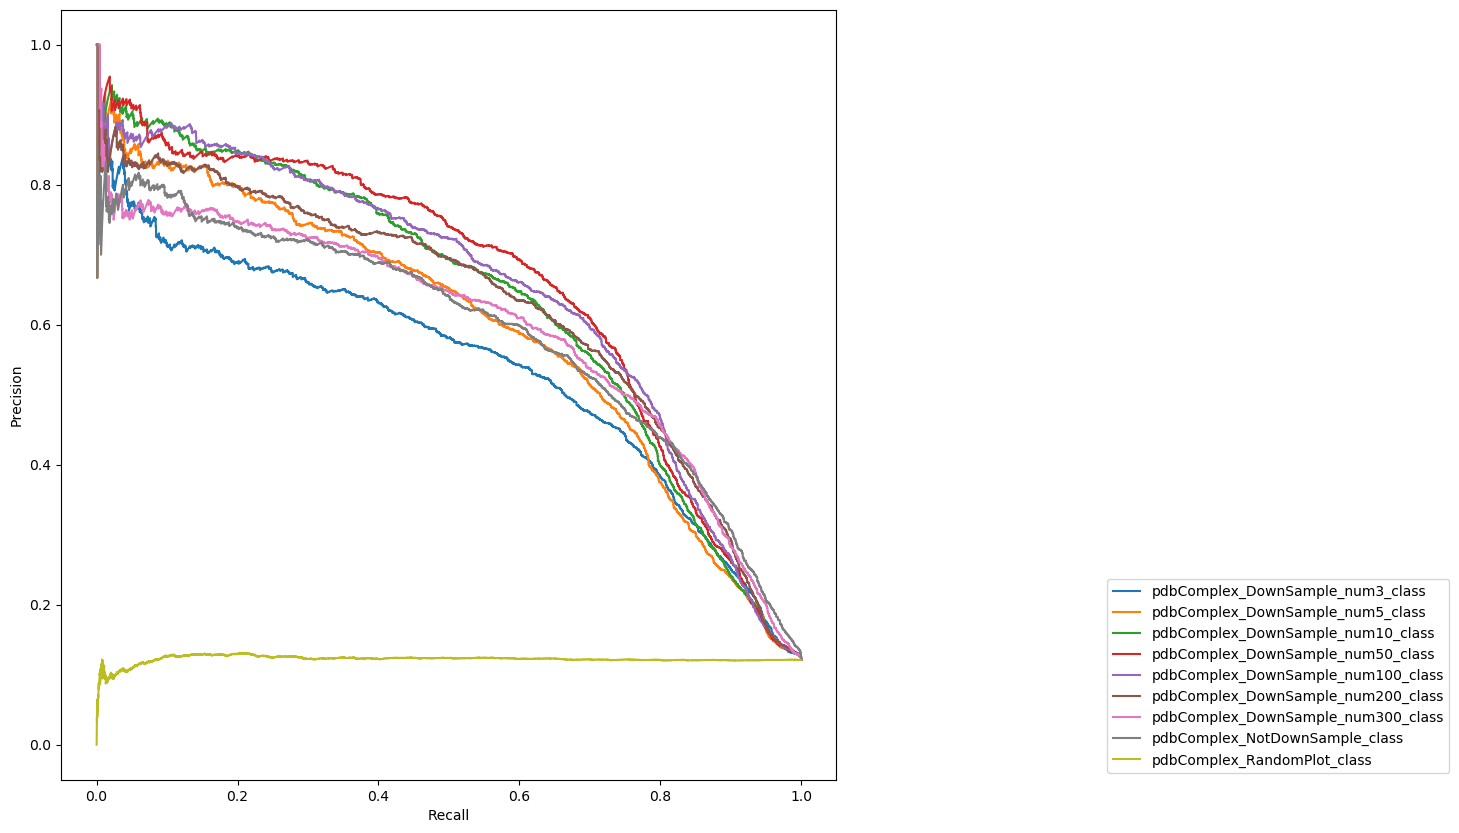

phylum
1224 511145 pdbComplex_DownSample_num3_
1224 511145 pdbComplex_DownSample_num5_
1224 511145 pdbComplex_DownSample_num10_
1224 511145 pdbComplex_DownSample_num50_
1224 511145 pdbComplex_DownSample_num100_
1224 511145 pdbComplex_DownSample_num200_
1224 511145 pdbComplex_DownSample_num300_


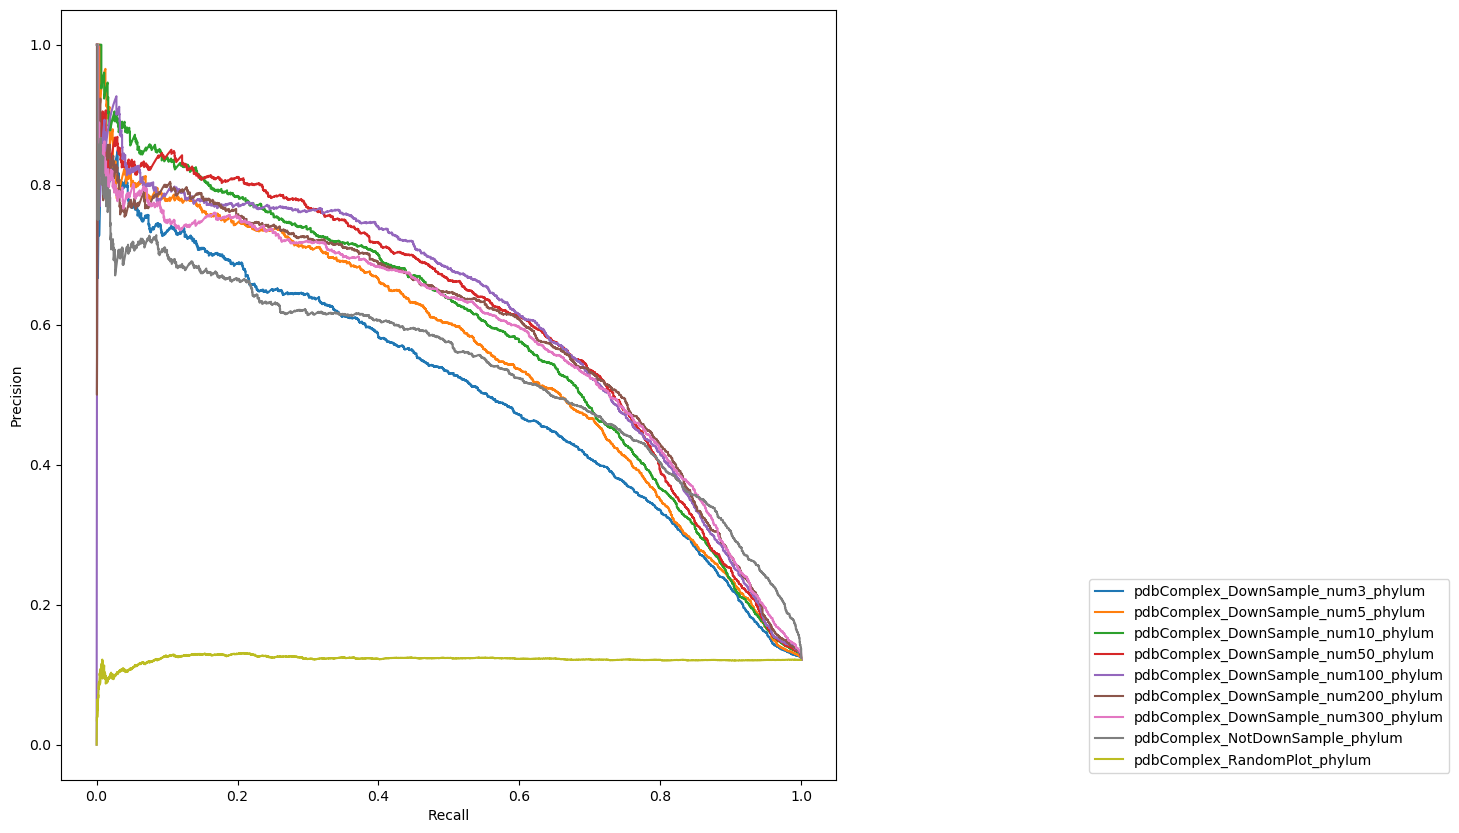

superkingdom
2 511145 pdbComplex_DownSample_num3_
2 511145 pdbComplex_DownSample_num5_
2 511145 pdbComplex_DownSample_num10_
2 511145 pdbComplex_DownSample_num50_
2 511145 pdbComplex_DownSample_num100_
2 511145 pdbComplex_DownSample_num200_
2 511145 pdbComplex_DownSample_num300_


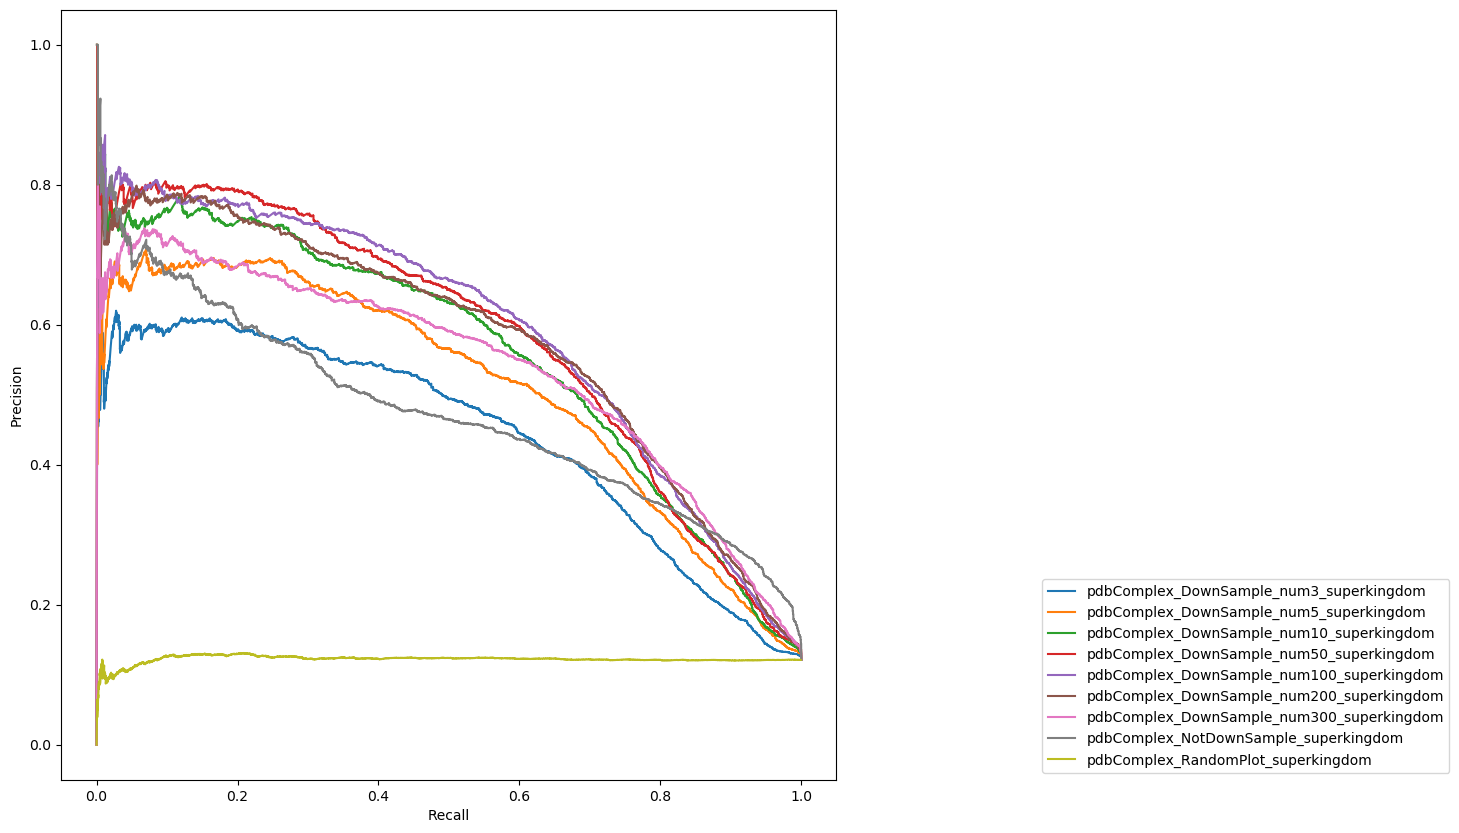

CPU times: user 1min 24s, sys: 69.2 ms, total: 1min 24s
Wall time: 1min 24s


In [57]:
%%time 
count_label="rate"
step=1
zoom_thres=None

ifplot=True
return_metrics=True
plotType="PR"



tiny_randomnoise_range=1e-7 # noice DCA is roumnd to 4 floating digits 

phylum2spe_list=[('1236', '511145'),('1224', '511145'),("2", "511145"),]  

DownSample_strategy = "num"#"percent"
# DownSample_sizes=[3,5,10,50,100,200,300,500,600]
# DownSample_sizes_lable=[3, 10, 50, 100, 200, 300, 500,"NotDownSample"]

DownSample_sizes=[0,3,5,10,50,100,200,300,600] #[3,5,10,50,100,200,300]
DownSample_sizes_lable=["RandomPlot",3, 5,10, 50, 100, 200, 300,"NotDownSample"]
columns_names=["class","phylum","superkingdom"]


samePos2NegRatio_pdbComplex_Taxa_PRAUC_table=pd.DataFrame(np.zeros((len(DownSample_sizes),3)),
                         index=DownSample_sizes_lable,
                         columns=columns_names)
samePos2NegRatio_pdbComplex_Taxa_ROCAUC_table=pd.DataFrame(np.zeros((len(DownSample_sizes),3)),
                         index=DownSample_sizes_lable,
                         columns=columns_names)
samePos2NegRatio_pdbComplex_medianDiff_table=pd.DataFrame(np.zeros((len(DownSample_sizes),3)),
                         index=DownSample_sizes_lable,
                         columns=columns_names)


for i,l in enumerate(phylum2spe_list): 
    
    column_name=columns_names[i]
    current_EggNOG_maxLevel,currentSpe_TaxID=l
    print(column_name)
    
    plt.figure(figsize=(10,10))
        
    for DownSample_size in DownSample_sizes[1:-1]:
        DownSamplePrefix="pdbComplex_DownSample_"+DownSample_strategy+str(DownSample_size)+"_"
        print(current_EggNOG_maxLevel,currentSpe_TaxID, DownSamplePrefix)

        ROC_AUC,PR_AUC,F1_score_lastStep,ACC_lastStep=DCA_RocCurve(testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]["XtopDCAs"][samePos2NegRatio_pdb_complex_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict[column_name],0], 
                     testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]["YtopDCAs"][samePos2NegRatio_pdb_complex_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict[column_name]],
                     count_label=count_label,legend=DownSamplePrefix+f"{column_name}",
                     step=step,zoom_thres=zoom_thres,tiny_randomnoise_range=tiny_randomnoise_range,
                    return_metrics=return_metrics,ifplot=ifplot,
                    plotType=plotType)
        samePos2NegRatio_pdbComplex_Taxa_PRAUC_table.loc[DownSample_size,column_name]=PR_AUC
        samePos2NegRatio_pdbComplex_Taxa_ROCAUC_table.loc[DownSample_size,column_name]=ROC_AUC
        
        
        medianDiff=check_FrameColMedian_diff(testPhylaEffectDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_resultDict[(current_EggNOG_maxLevel,currentSpe_TaxID,DownSample_strategy,DownSample_size)]['updated_allPPI_allInfo_frame'].iloc[samePos2NegRatio_pdb_complex_DownSampleSamePPs_STRING115EggNog2Spe511145_idx_dict[column_name],:])
        samePos2NegRatio_pdbComplex_medianDiff_table.loc[DownSample_size,column_name]=medianDiff

    if column_name=="superkingdom":
        temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog2Spe511145_topDCAs_predicted_results
    elif column_name=="phylum":
        temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1224Spe511145_topDCAs_predicted_results
    elif column_name=="class":
        temp_results=testPhylaEffectNotDownSampleSamePPs_STRING115EggNog1236Spe511145_topDCAs_predicted_results
    
    
    ROC_AUC,PR_AUC,F1_score_lastStep,ACC_lastStep=DCA_RocCurve(temp_results["XtopDCAs"][samePos2NegRatio_pdb_complex_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx,0], 
                 temp_results["YtopDCAs"][samePos2NegRatio_pdb_complex_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx],
                 count_label=count_label,legend=f"pdbComplex_NotDownSample_{column_name}",
                 step=step,zoom_thres=zoom_thres,tiny_randomnoise_range=tiny_randomnoise_range,
                 return_metrics=return_metrics,ifplot=ifplot,
                plotType=plotType)
    samePos2NegRatio_pdbComplex_Taxa_PRAUC_table.loc["NotDownSample",column_name]=PR_AUC
    samePos2NegRatio_pdbComplex_Taxa_ROCAUC_table.loc["NotDownSample",column_name]=ROC_AUC
    medianDiff=check_FrameColMedian_diff(temp_results['updated_allPPI_allInfo_frame'].iloc[samePos2NegRatio_pdb_complex_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx,:])
    samePos2NegRatio_pdbComplex_medianDiff_table.loc["NotDownSample",column_name]=medianDiff
    
    ROC_AUC,PR_AUC,F1_score_lastStep,ACC_lastStep=DCA_RocCurve(temp_results["XtopDCAs"][samePos2NegRatio_pdb_complex_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx,0], 
                 temp_results["YtopDCAs"][samePos2NegRatio_pdb_complex_NotDownSampleSamePPs_STRING115EggNog2Spe511145_idx],
                 count_label=count_label,legend=f"pdbComplex_RandomPlot_{column_name}",
                 step=step,zoom_thres=zoom_thres,tiny_randomnoise_range=tiny_randomnoise_range,
                 return_metrics=return_metrics,ifplot=ifplot,
                plotType=plotType,randomplot=True )
    samePos2NegRatio_pdbComplex_Taxa_PRAUC_table.loc["RandomPlot",column_name]=PR_AUC
    samePos2NegRatio_pdbComplex_Taxa_ROCAUC_table.loc["RandomPlot",column_name]=ROC_AUC

    
    plt.legend(bbox_to_anchor=(1.8,0), loc="lower right")
    #plt.legend().set_visible(False)
    plt.show()


# when step=1

In [58]:
# samePos2NegRatio_pdbComplex_medianDiff_table
samePos2NegRatio_pdbComplex_Taxa_PRAUC_table

,class,phylum,superkingdom
RandomPlot,0.1219,0.1219,0.1219
3,0.5424,0.5075,0.4444
5,0.5948,0.5584,0.5125
10,0.6363,0.5878,0.5603
50,0.6568,0.6068,0.5840
100,0.6483,0.6063,0.5920
200,0.6247,0.5906,0.5782
300,0.5945,0.5840,0.5406
NotDownSample,0.5896,0.5325,0.4743


### updateed figure 3b with same pos:neg ratio for pdb_direct and pdb_medaited benchmark 

In [59]:
pdbContact_Taxa_PRAUC_table

,class,phylum,superkingdom
RandomPlot,0.0104,0.0104,0.0104
3,0.0285,0.0295,0.0267
5,0.0363,0.0353,0.0264
10,0.0453,0.0405,0.0390
50,0.0555,0.0540,0.0379
100,0.0798,0.0727,0.0450
200,0.0990,0.1119,0.0897
300,0.1166,0.1272,0.0952
NotDownSample,0.1340,0.1923,0.2348


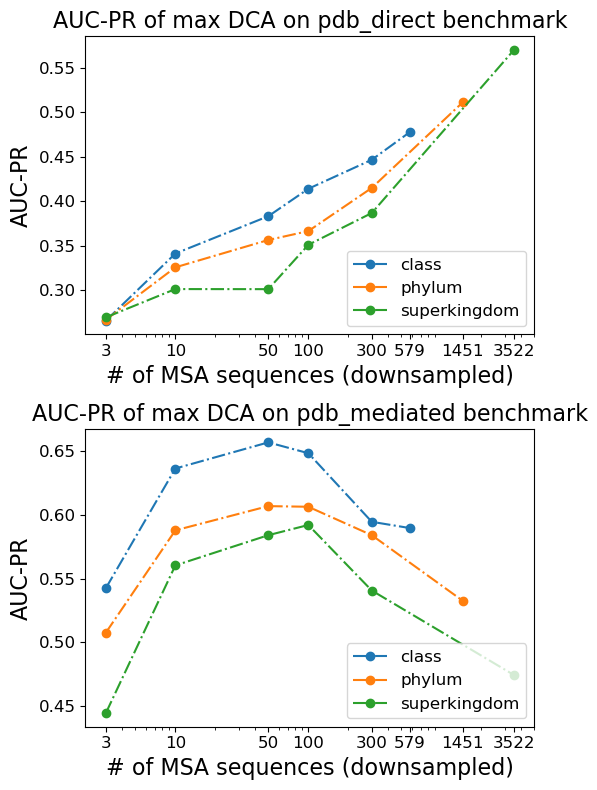

CPU times: user 563 ms, sys: 187 ms, total: 750 ms
Wall time: 510 ms


In [60]:
%%time 

DownSample_sizes=[3,10,50,100,300,600] #[3,5,10,50,100,200,300]
DownSample_sizes_lable=[3,10, 50, 100, 300,"NotDownSample"]


class_DownSample_sizes=DownSample_sizes[:-1]+[579]
phylum_DownSample_sizes=DownSample_sizes[:-1]+[1451]
superkingdom_DownSample_sizes=DownSample_sizes[:-1]+[3522]


fig2 = plt.figure(figsize=(6,8)) #plt.figure(figsize=(15,6)) figsize=(15,15)

ax1 = plt.subplot(2,1,1) #plt.subplot(1,3,1)
ax1.plot(class_DownSample_sizes,list(samePos2NegRatio_pdbContact_Taxa_PRAUC_table.loc[DownSample_sizes_lable,"class"]),label="class",
        linestyle="-.",marker="o")
ax1.plot(phylum_DownSample_sizes,list(samePos2NegRatio_pdbContact_Taxa_PRAUC_table.loc[DownSample_sizes_lable,"phylum"]),label="phylum",
        linestyle="-.",marker="o")
ax1.plot(superkingdom_DownSample_sizes,list(samePos2NegRatio_pdbContact_Taxa_PRAUC_table.loc[DownSample_sizes_lable,"superkingdom"]),label="superkingdom",
        linestyle="-.",marker="o")
# ax1.set_xticks(DownSample_sizes,DownSample_sizes_lable,fontsize=7,rotation=45,)
ax1.set_title("AUC-PR of max DCA on pdb_direct benchmark",fontsize=16)
#ax1.set_title("pdb_direct",loc='center',fontsize=10)
ax1.set_xlabel("# of MSA sequences (downsampled)",fontsize=16) #,loc='center'
ax1.set_ylabel("AUC-PR",fontsize=16)
ax1.set_xscale("log")
# ax1.set_xticks(DownSample_sizes[:-1]+[579,1451,3522],
#                DownSample_sizes[:-1]+[579,1451,3522],
#                # rotation=40,
#               )
ax1.set_xticks(DownSample_sizes[:-1]+[579,1451,3522],
              )
ax1.set_xticklabels(DownSample_sizes[:-1]+[579,1451,3522],
              )
plt.xticks(fontsize=12)# compare with ax2.set_xticks, this one dont need to give exact ticks position
plt.yticks(fontsize=12)
# plt.ylim(0.2,0.7)
ax1.legend( loc="lower right",fontsize=12)



ax2 = plt.subplot(2,1,2)
ax2.plot(class_DownSample_sizes,list(samePos2NegRatio_pdbComplex_Taxa_PRAUC_table.loc[DownSample_sizes_lable,"class"]),label="class",
        linestyle="-.",marker="o")
ax2.plot(phylum_DownSample_sizes,list(samePos2NegRatio_pdbComplex_Taxa_PRAUC_table.loc[DownSample_sizes_lable,"phylum"]),label="phylum",
        linestyle="-.",marker="o")
ax2.plot(superkingdom_DownSample_sizes,list(samePos2NegRatio_pdbComplex_Taxa_PRAUC_table.loc[DownSample_sizes_lable,"superkingdom"]),label="superkingdom",
        linestyle="-.",marker="o")
# ax2.set_xticks(DownSample_sizes,DownSample_sizes_lable,fontsize=7,rotation=45,)
ax2.set_title("AUC-PR of max DCA on pdb_mediated benchmark",fontsize=16)
ax2.set_xlabel("# of MSA sequences (downsampled)",fontsize=16) #,loc='center'
ax2.set_ylabel("AUC-PR",fontsize=16)
ax2.set_xscale("log")
# ax2.set_xticks(DownSample_sizes[:-1]+[579,1451,3522],
#                DownSample_sizes[:-1]+[579,1451,3522],
#                # rotation=40,
#               )
ax2.set_xticks(DownSample_sizes[:-1]+[579,1451,3522],
              )
ax2.set_xticklabels(DownSample_sizes[:-1]+[579,1451,3522],
              )
plt.xticks(fontsize=12)# compare with ax2.set_xticks, this one dont need to give exact ticks position
plt.yticks(fontsize=12)
# plt.ylim(0.2,0.7)
# ax2.set_ylabel("AUC-PR",loc='center',fontsize=10)

#plt.legend(bbox_to_anchor=(1.6,0),loc="lower right")ls
ax2.legend(loc="lower right",fontsize=12)



fig2.tight_layout()

plt.show()

fig2.savefig("/mnt/mnemo5/tao/temp_figures/Fig2.pdf", dpi=600)